# Intelligent Systems project [A.Y. 2024 / 2025]
## Vision-based spatiotemporal analysis of football matches
> Francesco De Lucchini - Salvatore La Porta

<br>
<br>
<br>

---

## `0` Preliminaries

---

> ### `0.1` Import the modules

In [1]:
# Instructions on how to download all the following dependencies are in the `README.txt` file
import os
import shutil
import random
import cv2
import torch
import yaml
import zipfile
import json

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import supervision as sv

from enum import Enum
from ultralytics import YOLO
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import deque
from collections import Counter
from collections import defaultdict
from pathlib import Path
from tqdm.notebook import tqdm

---

> ### `0.2` Check the hardware

In [2]:
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

CUDA Available: True
GPU Name: NVIDIA GeForce RTX 2060 SUPER


In [3]:
# If you are on linux
!nvidia-smi

Thu Jul 17 17:53:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.20             Driver Version: 570.133.20     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060 ...    Off |   00000000:26:00.0 Off |                  N/A |
|  0%   34C    P8             10W /  215W |      18MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

---

> ### `0.3` Initialize random components and global variables

In [4]:
SEED = 999
random.seed(SEED)
np.random.seed(SEED)

CLASS_NAMES = {
    0: "ball", 
    1: "goalkeeper", 
    2: "player",
    3: "referee"
}

CLASS_COLORS = {
    0: (255, 0, 255),   # ball       : fucsia
    1: (0, 255, 0),     # goalkeeper : green
    2: (0, 0, 255),     # player     : blue
    3: (255, 255, 0)    # referee    : yellow
}

# Basically CLASS_COLORS but values are normalized
CHART_COLORS = [
    (1, 0, 1),   # ball       : fucsia
    (0, 1, 0),   # goalkeeper : green
    (0, 0, 1),   # player     : blue
    (1, .8, 0),  # referee    : yellow (darker)
    (.2, .2, .2) # all        : dark gray
]

NUM_FOLDS = 5 # For k-fold validation
EPOCHS = 100  # Training epochs

DATASETS_PATH = Path.cwd().parent / "datasets"
os.makedirs(DATASETS_PATH, exist_ok=True)

# MatPlotLib
plt.rc('font', family='serif')
plt.rc('font', size=12)
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["axes.titlesize"] = 13

---

> The `original` dataset was obtained in the following way:
1. Download the YOLOv11 version of the dataset from https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/dataset/14
2. Unzip the downloaded dataset and merge the contents of `test`, `train` and `valid` folders into a single one named `original` 
3. The `original` dataset should now contain only two folders, `images` and `labels`, each one containing all the training data. (We will split the dataset later using K-fold validation)

<br>
<br>
<br>

---

## `1` Prepare the data

---

In [5]:
# A bunch of helper functions

def draw_yolo_annotations(image, label_path):
    """
    Draws YOLO-format bounding boxes on an image.

    Args:
        image (numpy.ndarray): The image on which to draw bounding boxes.
        label_path (str | pathlib.Path): Path to the YOLO-format label file. 
            Each line in the file should be in the format: 
                <class_id> <x_center> <y_center> <width> <height>, 
            with all values normalized between 0 and 1.

    Returns:
        numpy.ndarray: The image with bounding boxes and class labels drawn.
    """
    image_h, image_w = image.shape[:2]
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id, norm_box_x_center, norm_box_y_center, norm_box_w, norm_box_h = map(float, parts)
            class_id = int(class_id)
            
            # Convert YOLO's normalized coords to absolute pixel values
            box_x_center = norm_box_x_center * image_w
            box_y_center = norm_box_y_center * image_h
            box_width = norm_box_w * image_w
            box_height = norm_box_h * image_h

            # +/- 1 is to add a little padding
            x1 = int(box_x_center - box_width / 2) - 1
            y1 = int(box_y_center - box_height / 2) - 1
            x2 = int(box_x_center + box_width / 2) + 1
            y2 = int(box_y_center + box_height / 2) + 1

            class_color = CLASS_COLORS.get(class_id)
            cv2.rectangle(image, (x1, y1), (x2, y2), class_color, 2)   

            # Display class names [optional]
            #class_name = CLASS_NAMES.get(class_id)
            #cv2.putText(image, class_name, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, class_color, 1)
            
    return image

def draw_images_hsplit_layout(left_image, left_title, right_image, right_title, draw_legend=True):
    """
    Displays two images side by side with their respective titles and,
     optionally, a legend indicating class labels and colors.

    Args:
        left_image (numpy.ndarray): Image to display on the left.
        left_title (str): Title for the left image.
        right_image (numpy.ndarray): Image to display on the right.
        right_title (str): Title for the right image.
        draw_legend (bool): Whether to display the class labels and colors legend.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    axs[0].imshow(left_image)
    axs[0].set_title(left_title)
    axs[0].axis("off")
    
    axs[1].imshow(right_image)
    axs[1].set_title(right_title)
    axs[1].axis("off")
    
    patches = []
    for class_id, class_name in CLASS_NAMES.items():
        # Normalize the colors to [0, 1] for matplotlib
        color = [c / 255 for c in CLASS_COLORS[class_id]] 
        patch = mpatches.Patch(color=color, label=class_name)
        patches.append(patch)

    if draw_legend:
        legend = axs[1].legend(
            handles=patches,
            loc='upper center',
            bbox_to_anchor=(0.5, 1.0),
            ncol=len(CLASS_NAMES),
            fontsize=11.38,
            frameon=True
        )
    
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_edgecolor('black')
        frame.set_linewidth(1.5)
        frame.set_alpha(1.0) # No transparency
        frame.set_boxstyle('square')
    
    plt.tight_layout()
    plt.show()

def display_annotated_image(image_path, label_path):
    """
    Displays the given image next to its annotated (groud-truth) version.

    Args:
        image_path (str | pathlib.Path): Path to the image file.
        label_path (str | pathlib.Path): Path to the corresponding YOLO-format label file.
    """
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    annotated_image = draw_yolo_annotations(original_image.copy(), label_path)
    
    draw_images_hsplit_layout(
        original_image, "Original image",
        annotated_image, "Annotated image (ground truth)"
    )
    
def display_random_annotated_image(dataset_path):
    """
    Displays a random image of the given dataset next to its annotated (groud-truth) version.

    Args:
        dataset_path (pathlib.Path): The path of the dataset.
    """
    image_filenames = os.listdir(dataset_path / "images")
    random_image_path = dataset_path / "images" / random.choice(image_filenames)
    random_label_path = dataset_path / "labels" / (random_image_path.stem + ".txt")
    
    print(f"Random image: {random_image_path}")
    print(f"Corresponding label: {random_label_path}")
    display_annotated_image(random_image_path, random_label_path)

def load_dataset_into_df(dataset_path):
    """
    Builds a Pandas DataFrame that has labels filenames as row index and yolo classes as columns.

    Args:
        dataset_path (pathlib.Path): The path of the dataset.
    """
    label_filenames = os.listdir(dataset_path / "labels")
    
    dataset_df = pd.DataFrame([], columns=CLASS_NAMES.keys(), index=label_filenames)
    
    for label_filename in label_filenames:
        lbl_counter = Counter()
    
        label_path = dataset_path / "labels" / label_filename
        with open(label_path) as label:
            lines = label.readlines()
    
        for line in lines:
            # The class id is the first word of the YOLO label format
            class_id = int(line.split(" ", 1)[0])
            lbl_counter[class_id] += 1
    
        dataset_df.loc[label_filename] = lbl_counter
    
    dataset_df = dataset_df.rename(columns=CLASS_NAMES)
    dataset_df = dataset_df.infer_objects(copy=False).fillna(0)
    dataset_df = dataset_df.astype(int)
    
    return dataset_df

def display_annotated_images(labels_df, dataset_path):
    """
    Displays all the given images next to their annotated (groud-truth) versions.

    Args:
        labels_df (pandas.DataFrame): DataFrame with label filenames as its index.
        dataset_path (pathlib.Path): The dataset containing the provided label filenames.
    """
    label_names = list(labels_df.index)
    for label_name in label_names:
        label_path = dataset_path / "labels" / label_name
        image_path = dataset_path / "images" / (label_path.stem + ".jpg") 
        print(f"\n{image_path}:")
        display_annotated_image(image_path, label_path)

---

> ### `1.1` Explore

Random image: /home/fra/Desktop/IS/datasets/original/images/2e57b9_5_10_png.rf.fcacf946ebdd257b96315eaf1ed8f461.jpg
Corresponding label: /home/fra/Desktop/IS/datasets/original/labels/2e57b9_5_10_png.rf.fcacf946ebdd257b96315eaf1ed8f461.txt


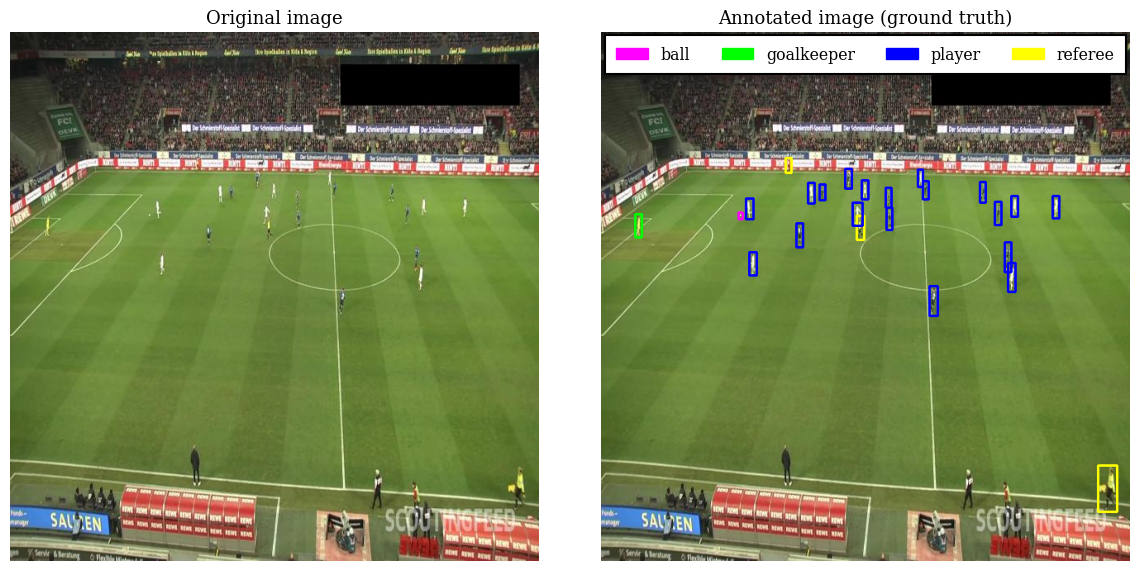

In [6]:
original_dataset_path = DATASETS_PATH / "original"
display_random_annotated_image(original_dataset_path)

In [7]:
original_df = load_dataset_into_df(original_dataset_path)
display(original_df)

ball  goalkeeper  player  \
cd987c_0_4_png.rf.16560704fb0e8299a44c070c990cc...     1           1      20   
2e57b9_1_7_png.rf.5f46fe305647ee8f1505f90314298...     1           1      20   
54745b_1_7_png.rf.e648b45e1a357dfd8a5d4751bfc70...     1           1      20   
2e57b9_1_6_png.rf.6b7e21a178988dbf6585781f9194a...     1           1      20   
744b27_3_2_png.rf.6b748142add45f5674a7e604fa4c1...     1           1      19   
...                                                  ...         ...     ...   
40cd38_7_6_png.rf.9086647de5bd5996fba2572de102d...     1           1      20   
744b27_3_7_png.rf.a183daa734d8ae1787aa4f3a769d5...     1           1      20   
42ba34_3_10_png.rf.df47740b30bc9c39f67dc2a8721c...     1           2      20   
538438_7_7_png.rf.2520f0a96a2c29538a5951ced4d2d...     2           0      20   
a9f16c_2_2_png.rf.1cabe56f7ed17ebb7012e5bfc905e...     1           1      20   

                                                    referee  
cd987c_0_4_png.rf.16560704fb0e8299a44c070c990cc...        3  
2e57b9_1_7_png.rf.5f46fe305647ee8f1505f90314298...        3  
54745b_1_7_png.rf.e648b45e1a357dfd8a5d4751bfc70...        3  
2e57b9_1_6_png.rf.6b7e21a178988dbf6585781f9194a...        3  
744b27_3_2_png.rf.6b748142add45f5674a7e604fa4c1...        3  
...                                                     ...  
40cd38_7_6_png.rf.9086647de5bd5996fba2572de102d...        2  
744b27_3_7_png.rf.a183daa734d8ae1787aa4f3a769d5...        2  
42ba34_3_10_png.rf.df47740b30bc9c39f67dc2a8721c...        2  
538438_7_7_png.rf.2520f0a96a2c29538a5951ced4d2d...        3  
a9f16c_2_2_png.rf.1cabe56f7ed17ebb7012e5bfc905e...        2  

[372 rows x 4 columns]

In [8]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 372 entries, cd987c_0_4_png.rf.16560704fb0e8299a44c070c990cc455.txt to a9f16c_2_2_png.rf.1cabe56f7ed17ebb7012e5bfc905eafb.txt
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   ball        372 non-null    int64
 1   goalkeeper  372 non-null    int64
 2   player      372 non-null    int64
 3   referee     372 non-null    int64
dtypes: int64(4)
memory usage: 22.6+ KB


In [9]:
original_df.describe()

ball  goalkeeper      player     referee
count  372.000000  372.000000  372.000000  372.000000
mean     0.879032    0.774194   19.965054    2.319892
std      0.342641    0.516656    0.504817    0.603076
min      0.000000    0.000000   17.000000    0.000000
25%      1.000000    0.000000   20.000000    2.000000
50%      1.000000    1.000000   20.000000    2.000000
75%      1.000000    1.000000   20.000000    3.000000
max      2.000000    2.000000   22.000000    3.000000

---

> ### `1.2` Check the consistency

ball  goalkeeper  player  \
4b770a_1_6_png.rf.c243d08b8a11de2a1939459900d6a...     2           0      20   
538438_7_7_png.rf.2520f0a96a2c29538a5951ced4d2d...     2           0      20   

                                                    referee  
4b770a_1_6_png.rf.c243d08b8a11de2a1939459900d6a...        3  
538438_7_7_png.rf.2520f0a96a2c29538a5951ced4d2d...        3


/home/fra/Desktop/IS/datasets/original/images/4b770a_1_6_png.rf.c243d08b8a11de2a1939459900d6a810.jpg:


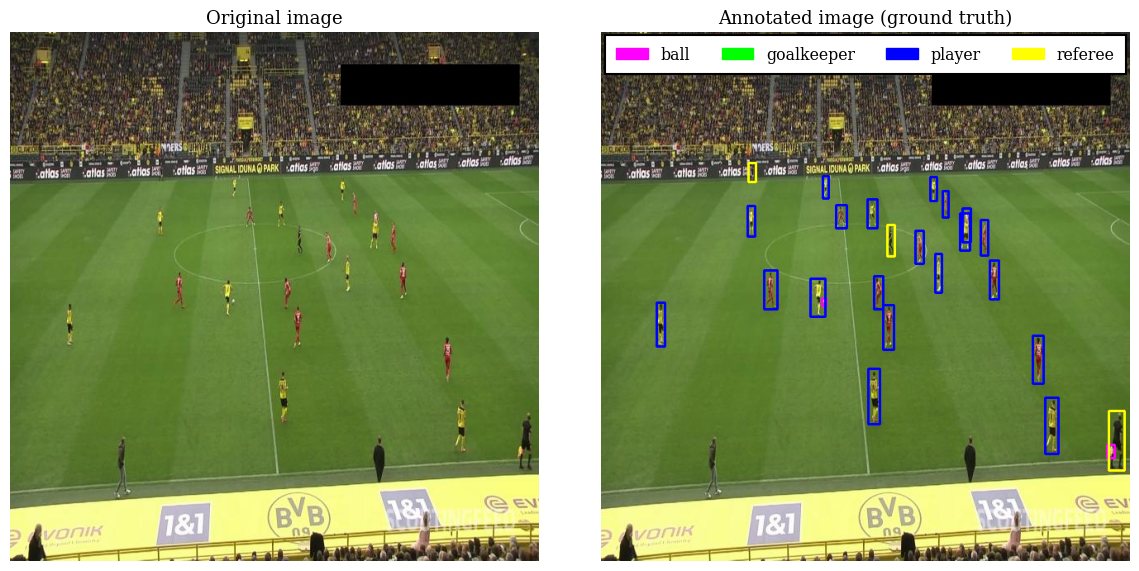


/home/fra/Desktop/IS/datasets/original/images/538438_7_7_png.rf.2520f0a96a2c29538a5951ced4d2d689.jpg:


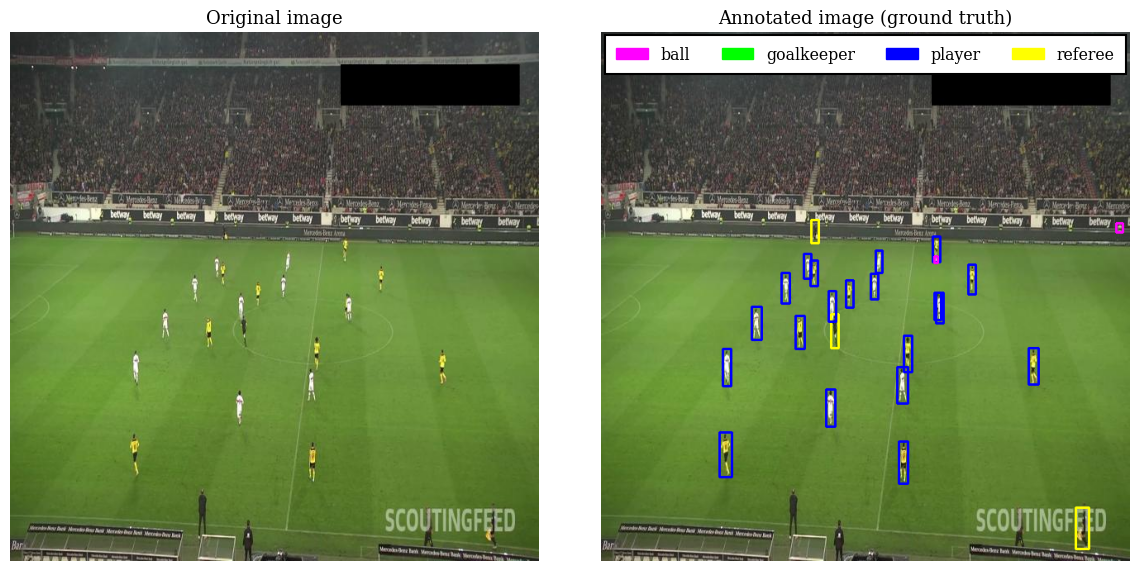

In [10]:
# Are there any images with more than one ball?
filtered_df = original_df[original_df["ball"] > 1]
display(filtered_df)
display_annotated_images(filtered_df, original_dataset_path)

ball  goalkeeper  player  \
4b770a_5_3_png.rf.f45a7bbfc725cd01860c7386e62e9...     1           1      21   
538438_3_7_png.rf.a141ac8fb12df5a015d0ebc9842b8...     0           0      21   
4b770a_9_8_png.rf.bc00598d90ca1665d0cd887e25f3e...     1           0      22   
744b27_7_3_png.rf.5932a1c381e069b7c4654f288e499...     1           0      21   
4b770a_9_5_png.rf.918064f4b94f571bfbda8964da0fd...     1           1      22   
40cd38_7_7_png.rf.233f302be90e57f9b8e7c54a96b1c...     1           0      21   
573e61_9_4_png.rf.183d982401f8eff5589a0bb0e43ab...     1           1      22   
4b770a_5_6_png.rf.487846b612bd582295576bee79dc4...     1           0      21   
798b45_7_4_png.rf.403c25ef7dc47c67aa799007ff6df...     1           1      21   
4b770a_9_9_png.rf.a393118aeb57dd480f5827d4806b9...     0           1      22   
573e61_3_8_png.rf.40c0d9f686e7c411c46fb433b58c8...     1           0      21   
4b770a_1_7_png.rf.ffd396992be8d17db9f7cdb27ee28...     1           0      21   
538438_3_10_png.rf.0a4a80ccebb63680081103b95f47...     0           1      21   
cd987c_9_10_png.rf.bb3e19e1b9824010614a64211d10...     1           1      21   
573e61_1_8_png.rf.4536318cff003e03b212eb2a1919e...     1           0      21   
2e57b9_3_10_png.rf.d555c55585a3e1b2812f899accd8...     1           1      21   
42ba34_5_2_png.rf.a15802bd457fe03db741c07278687...     1           0      21   
798b45_3_5_png.rf.7ae683eac87ec297ab42ebf90f383...     1           1      21   
573e61_7_8_png.rf.6ead9cf6a86b3be1060c4536d9799...     1           1      21   
2e57b9_3_3_png.rf.426132799361ec88d5628f8261acb...     1           1      21   
08fd33_0_2_png.rf.13387b7cca5c38f0e9094e9acc5bc...     1           0      21   
538438_7_5_png.rf.f69625b7cd544df3dc7ca16d1e375...     1           0      21   
744b27_5_3_png.rf.713ec3d0d8489980e67c31f5ca084...     1           1      21   
4b770a_9_4_png.rf.9b7571c8715ff9ca6fea1a682cabe...     1           1      22   
a9f16c_8_4_png.rf.da8eb65ef202e35cc35e4055be325...     1           1      21   

                                                    referee  
4b770a_5_3_png.rf.f45a7bbfc725cd01860c7386e62e9...        2  
538438_3_7_png.rf.a141ac8fb12df5a015d0ebc9842b8...        3  
4b770a_9_8_png.rf.bc00598d90ca1665d0cd887e25f3e...        2  
744b27_7_3_png.rf.5932a1c381e069b7c4654f288e499...        3  
4b770a_9_5_png.rf.918064f4b94f571bfbda8964da0fd...        3  
40cd38_7_7_png.rf.233f302be90e57f9b8e7c54a96b1c...        3  
573e61_9_4_png.rf.183d982401f8eff5589a0bb0e43ab...        0  
4b770a_5_6_png.rf.487846b612bd582295576bee79dc4...        3  
798b45_7_4_png.rf.403c25ef7dc47c67aa799007ff6df...        1  
4b770a_9_9_png.rf.a393118aeb57dd480f5827d4806b9...        2  
573e61_3_8_png.rf.40c0d9f686e7c411c46fb433b58c8...        3  
4b770a_1_7_png.rf.ffd396992be8d17db9f7cdb27ee28...        2  
538438_3_10_png.rf.0a4a80ccebb63680081103b95f47...        3  
cd987c_9_10_png.rf.bb3e19e1b9824010614a64211d10...        1  
573e61_1_8_png.rf.4536318cff003e03b212eb2a1919e...        2  
2e57b9_3_10_png.rf.d555c55585a3e1b2812f899accd8...        3  
42ba34_5_2_png.rf.a15802bd457fe03db741c07278687...        2  
798b45_3_5_png.rf.7ae683eac87ec297ab42ebf90f383...        2  
573e61_7_8_png.rf.6ead9cf6a86b3be1060c4536d9799...        2  
2e57b9_3_3_png.rf.426132799361ec88d5628f8261acb...        3  
08fd33_0_2_png.rf.13387b7cca5c38f0e9094e9acc5bc...        3  
538438_7_5_png.rf.f69625b7cd544df3dc7ca16d1e375...        3  
744b27_5_3_png.rf.713ec3d0d8489980e67c31f5ca084...        1  
4b770a_9_4_png.rf.9b7571c8715ff9ca6fea1a682cabe...        3  
a9f16c_8_4_png.rf.da8eb65ef202e35cc35e4055be325...        2


The referee is wrongly labeled as player

/home/fra/Desktop/IS/datasets/original/images/4b770a_5_3_png.rf.f45a7bbfc725cd01860c7386e62e958a.jpg:


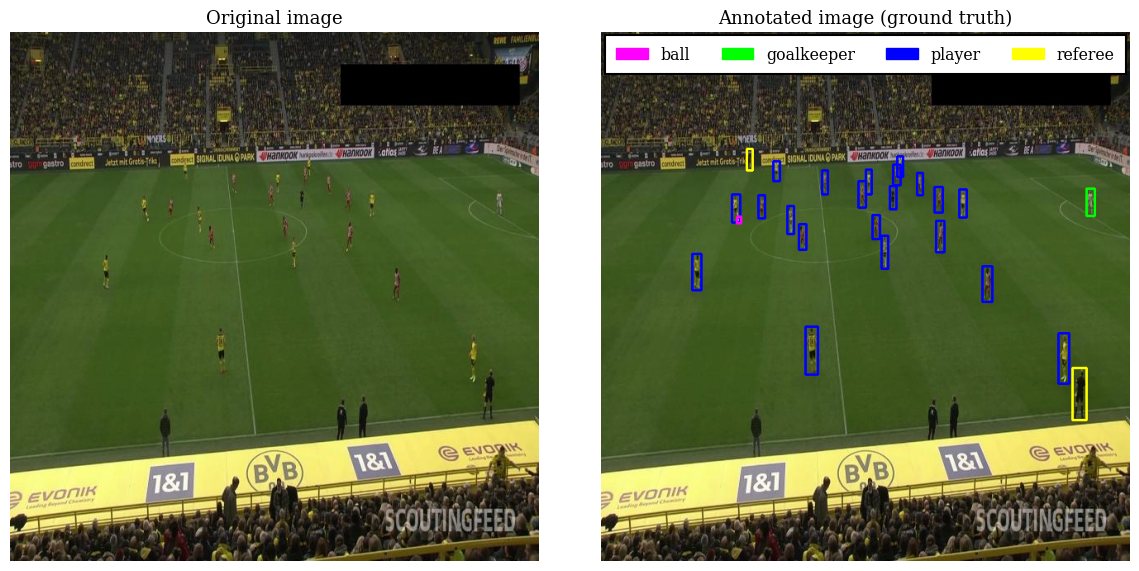


There are substitute players ready to come in wrongly labeled as active players

/home/fra/Desktop/IS/datasets/original/images/4b770a_9_8_png.rf.bc00598d90ca1665d0cd887e25f3e7f4.jpg:


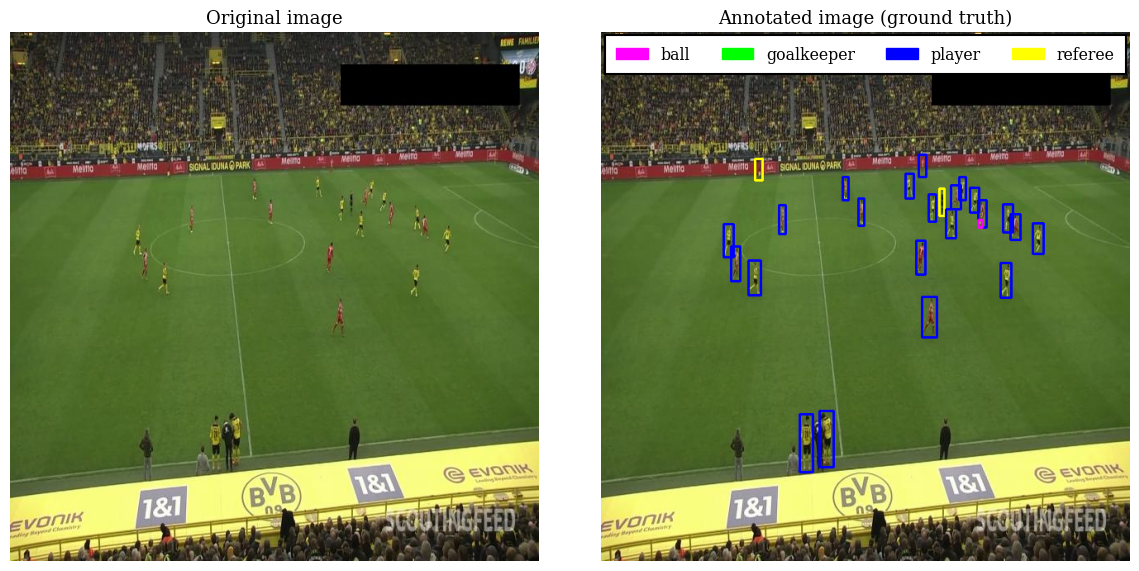


The goalkeepers are wrongly labeled as players

/home/fra/Desktop/IS/datasets/original/images/744b27_7_3_png.rf.5932a1c381e069b7c4654f288e499162.jpg:


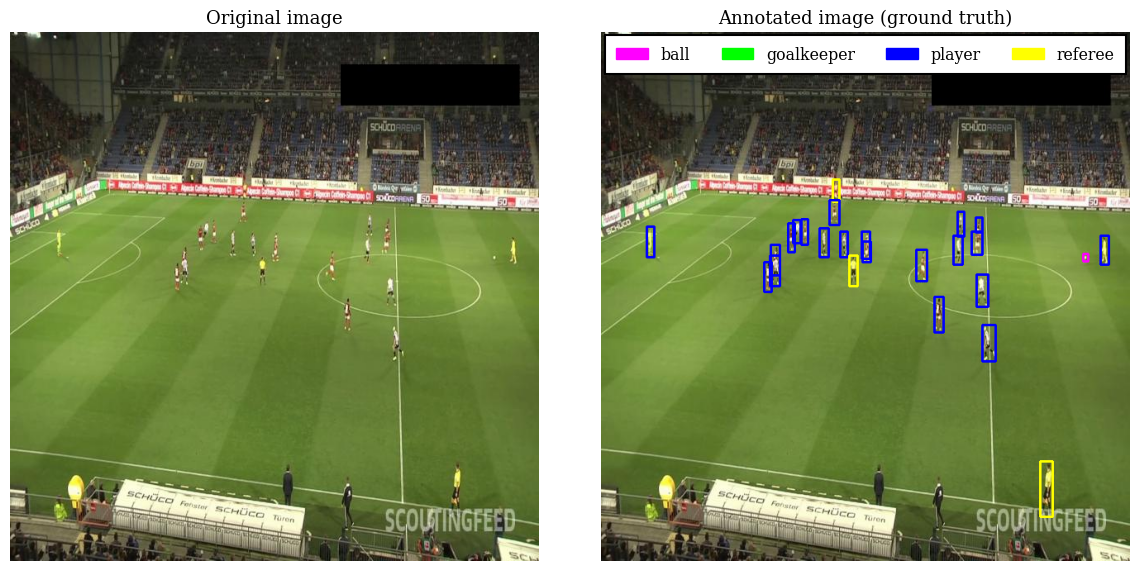


The manager is wrongly labeled as player

/home/fra/Desktop/IS/datasets/original/images/2e57b9_3_10_png.rf.d555c55585a3e1b2812f899accd8e4ea.jpg:


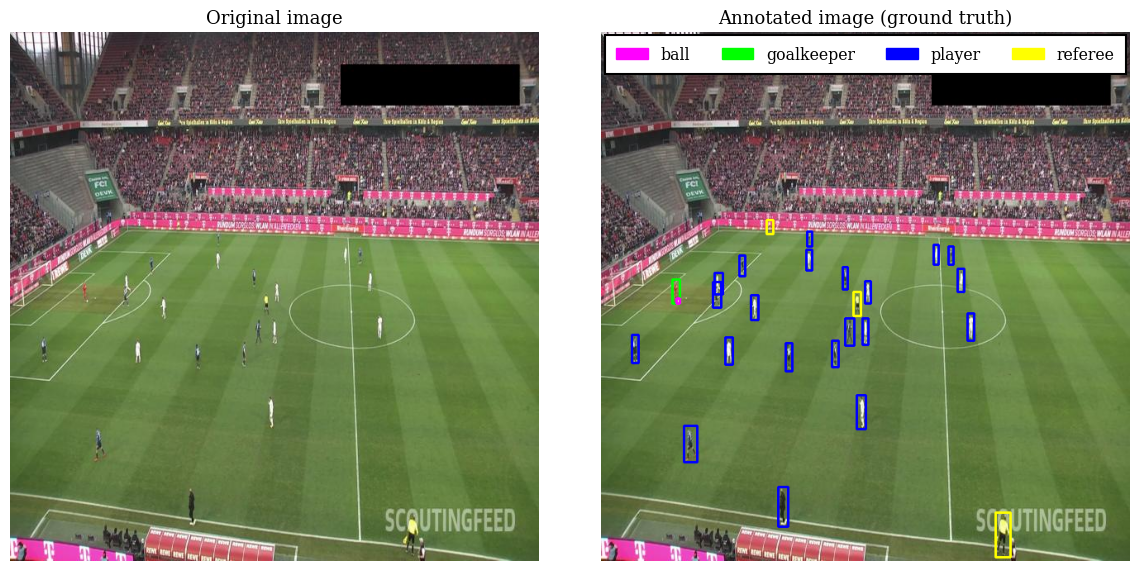

In [11]:
# Are there any images with more than 20 players (excluding goalkeepers)?
filtered_df = original_df[original_df["player"] > 20]
display(filtered_df)

# Quite a few, let's see some examples

print("\nThe referee is wrongly labeled as player")
display_annotated_images(filtered_df.iloc[[0]], original_dataset_path)

print("\nThere are substitute players ready to come in wrongly labeled as active players")
display_annotated_images(filtered_df.iloc[[2]], original_dataset_path)

print("\nThe goalkeepers are wrongly labeled as players")
display_annotated_images(filtered_df.iloc[[3]], original_dataset_path)

print("\nThe manager is wrongly labeled as player")
display_annotated_images(filtered_df.iloc[[15]], original_dataset_path)

In [12]:
# Are there any labels with more than 2 goalkeepers?
filtered_df = original_df[original_df["goalkeeper"] > 2]
display(filtered_df)
display_annotated_images(filtered_df, original_dataset_path)

# Luckily there are none

Empty DataFrame
Columns: [ball, goalkeeper, player, referee]
Index: []

ball  goalkeeper  player  \
573e61_9_4_png.rf.183d982401f8eff5589a0bb0e43ab...     1           1      22   

                                                    referee  
573e61_9_4_png.rf.183d982401f8eff5589a0bb0e43ab...        0


/home/fra/Desktop/IS/datasets/original/images/573e61_9_4_png.rf.183d982401f8eff5589a0bb0e43aba10.jpg:


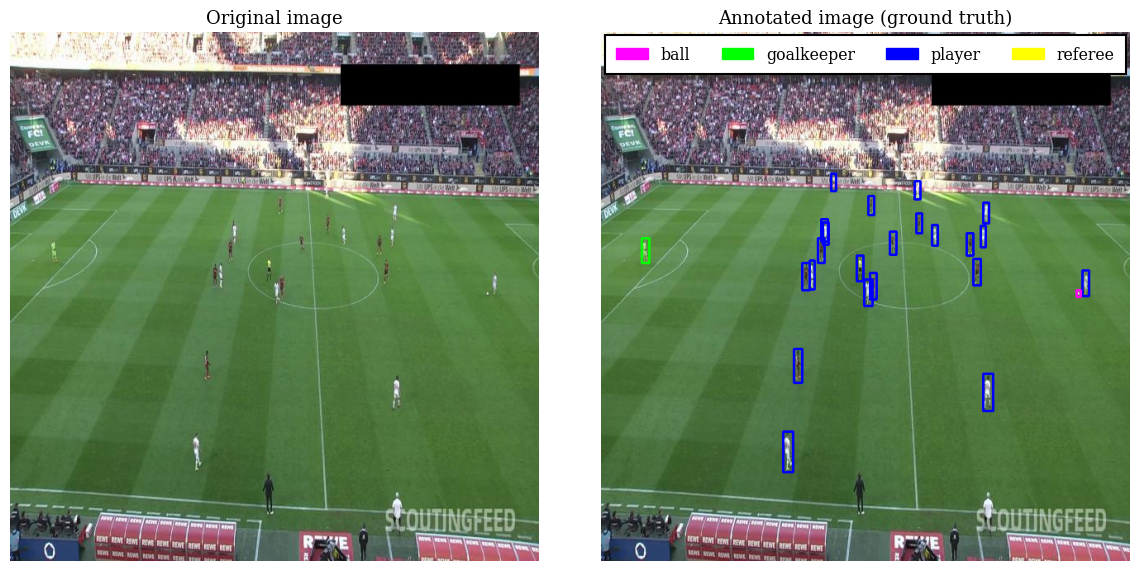

In [13]:
# Are there any labels with either 0 or more than 3 referees (linesman also count as refs)?
filtered_df = original_df[(original_df['referee'] == 0) | (original_df['referee'] > 3)]
display(filtered_df)
display_annotated_images(filtered_df, original_dataset_path)

---

> ### `1.3` Refine

Due to the relatively low quality of the original dataset, we manually reviewed all 372 images it contained and, when necessary, we re-annotated the images using [Label Studio](https://labelstud.io/). Additionally, we expanded the dataset by introducing 28 new images, bringing the total to 400. This revised and enhanced version of the dataset is available in the `datasets/refined` folder.

Random image: /home/fra/Desktop/IS/datasets/refined/images/42ba34_1_4_png.rf.63c0b1b974071f84b5adeed023c5f5b8.jpg
Corresponding label: /home/fra/Desktop/IS/datasets/refined/labels/42ba34_1_4_png.rf.63c0b1b974071f84b5adeed023c5f5b8.txt


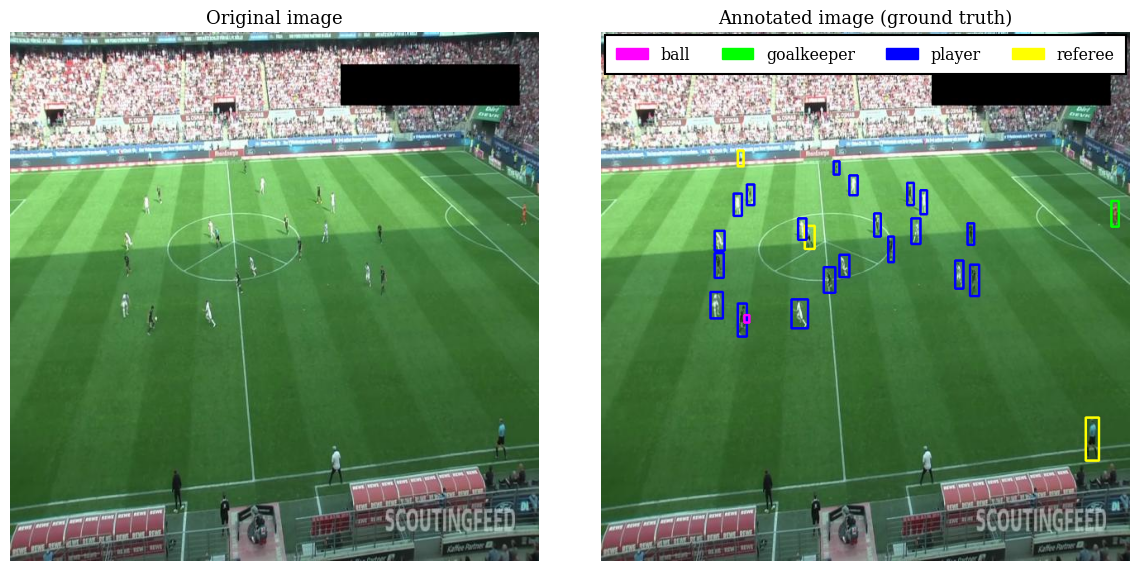

In [14]:
refined_dataset_path = DATASETS_PATH / "refined"
display_random_annotated_image(refined_dataset_path)

In [15]:
refined_df = load_dataset_into_df(refined_dataset_path)
display(refined_df)

ball  goalkeeper  player  \
cd987c_0_4_png.rf.16560704fb0e8299a44c070c990cc...     1           1      20   
2187ffde-HlOafTJGO6TXCbY9hElshZjEFQTX1iEH7dxQYC...     1           1      20   
76cac060-eBzMGHb7HkXvmaoI5ttpx5I4tfLToKqQzizzov...     1           1      20   
2e57b9_1_7_png.rf.5f46fe305647ee8f1505f90314298...     1           1      20   
54745b_1_7_png.rf.e648b45e1a357dfd8a5d4751bfc70...     1           1      20   
...                                                  ...         ...     ...   
40cd38_7_6_png.rf.9086647de5bd5996fba2572de102d...     1           1      20   
744b27_3_7_png.rf.a183daa734d8ae1787aa4f3a769d5...     1           1      20   
42ba34_3_10_png.rf.df47740b30bc9c39f67dc2a8721c...     1           2      20   
538438_7_7_png.rf.2520f0a96a2c29538a5951ced4d2d...     2           0      20   
a9f16c_2_2_png.rf.1cabe56f7ed17ebb7012e5bfc905e...     1           1      20   

                                                    referee  
cd987c_0_4_png.rf.16560704fb0e8299a44c070c990cc...        3  
2187ffde-HlOafTJGO6TXCbY9hElshZjEFQTX1iEH7dxQYC...        3  
76cac060-eBzMGHb7HkXvmaoI5ttpx5I4tfLToKqQzizzov...        2  
2e57b9_1_7_png.rf.5f46fe305647ee8f1505f90314298...        3  
54745b_1_7_png.rf.e648b45e1a357dfd8a5d4751bfc70...        3  
...                                                     ...  
40cd38_7_6_png.rf.9086647de5bd5996fba2572de102d...        2  
744b27_3_7_png.rf.a183daa734d8ae1787aa4f3a769d5...        2  
42ba34_3_10_png.rf.df47740b30bc9c39f67dc2a8721c...        2  
538438_7_7_png.rf.2520f0a96a2c29538a5951ced4d2d...        3  
a9f16c_2_2_png.rf.1cabe56f7ed17ebb7012e5bfc905e...        2  

[400 rows x 4 columns]

---

> ### `1.4` Split

A traditional approach to model development and evaluation involves splitting the data into three sets:
- **Train**: Used to fit the model(s)
- **Validation**: Used to tune hyperparameters (e.g., selecting between models or model variants)
- **Test**: Used to evaluate the generalization performance of the final selected model on truly unseen data

However, since our dataset is relatively small (400 records), each split might, by chance, include samples that are particularly easy or difficult to predict. This could lead to biased performance estimates. 

To address this, we adopt **K-fold cross-validation**:
1. First, we split the dataset into:
   - **Training set** (80%)
   - **Test set** (20%)
2. Then, we apply **5-fold cross-validation** on the training set and select the best model based on the average performances on the validation splits
3. Finally, we train again the best model on the full training set and evaluate its performances on the hold-out test set, which was never seen during training or model selection

<img src="media/data_splitting.png" alt="Cross validation image" width="600"/>

> Ideally, with small datasets, one would adopt **nested cross-validation**, i.e., repeating the entire process across different test splits to get a more robust estimate (a less computational intensive, but still valid, approach is to repeat an arbitraty number of times the scheme above with a different seed). However, due to computational constraints, we opted for a single test split.

We implemented the splitting strategy described above in the following way:

```
datasets
├── data={DATASET_NAME}-folds={NUM_FOLDS}-seed={SEED}
│   ├── full             # The full dataset
│   │   ├── config.yaml  
│   │   ├── train          # 80% training set (used for training the final model after selection)
│   │   │   ├── images
│   │   │   └── labels
│   │   └── val            # 20% test set (it's called val due to constraints of the YOLO framework)
│   │   │   ├── images
│   │   │   └── labels
│   ├── fold_1           # K-Fold splits        
│   │   ├── config.yaml
│   │   ├── train
│   │   │   ├── images
│   │   │   └── labels
│   │   └── val
│   │   │   ├── images
│   │   │   └── labels
│   ├── fold_2
...
```

The `config.yaml` files are required by the YOLO training framework and must have the following format:
```
names:
  {class_id}: {class_name}
# In our case
  0: ball
  1: referee
  2: player
  3: goalkeeper 
#
train: train
val: val
```

In [16]:
# Helper functions

def create_dataset_config_file(config_file_path):
    """
    Creates a YAML configuration file for a YOLO-style dataset split with 
    'train' and 'val' paths and the class names used for annotation.

    Args:
        config_file_path (str | pathlib.Path): Path where the YAML configuration file will be saved.
    """
    with open(config_file_path, "w") as conf:
        yaml.safe_dump(
            {
                "train": "train",
                "val": "val",
                "names": CLASS_NAMES,
            },
            conf
        )

def copy_label_and_image(label_filename, dataset_path, dest_dir):  
    """
    Copies the label and corresponding image file from the dataset directory to the specified destination directory.

    Args:
        label_filename (str | pathlib.Path): The filename of the label (e.g., "abc.txt").
        dataset_path (pathlib.Path): Path to the root dataset directory containing 'images/' and 'labels/' subfolders.
        dest_dir (pathlib.Path): Destination directory where the label and image should be copied.
    """
    label_src_path = dataset_path / "labels" / label_filename
    image_src_path = dataset_path / "images" / (label_src_path.stem  + ".jpg")

    label_dst_path = dest_dir / "labels" / label_src_path.name
    image_dst_path = dest_dir / "images" / image_src_path.name
        
    shutil.copy(image_src_path, image_dst_path)
    shutil.copy(label_src_path, label_dst_path)

def create_folder_structure(kfold_dataset_path, fold_names):
    """
    Creates the necessary directory structure and config files for the splitting strategy described above

    Args:
        kfold_dataset_path (pathlib.Path): Root path where the k-fold dataset structure will be created.
        fold_names (list of str): List of fold directory names (e.g., ['fold_1', 'fold_2', ...]).
    """
    (kfold_dataset_path / "full" / "train" / "images").mkdir(parents=True)
    (kfold_dataset_path / "full" / "train" / "labels").mkdir(parents=True)
    (kfold_dataset_path / "full" / "val" / "images").mkdir(parents=True) # Here val = the test set
    (kfold_dataset_path / "full" / "val" / "labels").mkdir(parents=True) # Here val = the test set
    create_dataset_config_file(kfold_dataset_path / "full" / "config.yaml")
                    
    for fold_name in fold_names:
        fold_path = kfold_dataset_path / fold_name

        fold_path.mkdir()
        (fold_path / "train" / "images").mkdir(parents=True)
        (fold_path / "train" / "labels").mkdir(parents=True)
        (fold_path / "val" / "images").mkdir(parents=True)
        (fold_path / "val" / "labels").mkdir(parents=True)

        create_dataset_config_file(fold_path / "config.yaml")

def split_dataset(dataset_df, dataset_path):
    """
    Splits a dataset according to the splitting strategy described above
    
    Args:
        dataset_df (pandas.DataFrame): DataFrame with label filenames as its index.
        dataset_path (pathlib.Path): Path to the root dataset directory containing 'images/' and 'labels/' subfolders.
    """
    kfold_dataset_path = DATASETS_PATH / f"data={dataset_path.stem}-folds={NUM_FOLDS}-seed={SEED}"
    
    if kfold_dataset_path.is_dir():
        print(f"Skipping the creation of the k-fold dataset '{kfold_dataset_path.stem}' since it already exists on disk")
        return
    kfold_dataset_path.mkdir()
    
    train_df, test_df = train_test_split(
        dataset_df,
        test_size=0.2,
        random_state=SEED,
        shuffle=True
    )
    
    print("# Test set #")
    display(test_df.drop(columns=test_df.columns))
    
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
    kfold_indexes = list(kf.split(train_df))
    
    fold_names = [f"fold_{n}" for n in range(1, NUM_FOLDS + 1)]
    folds_df = pd.DataFrame(index=train_df.index, columns=fold_names)
    
    # "train" and "val" are arrays of indexes representing which images to pick
    # "i" represents the current fold (1 to NUM_FOLDS)
    for i, (train, val) in enumerate(kfold_indexes, start=1):
        folds_df.loc[train_df.iloc[train].index, f"fold_{i}"] = "train"
        folds_df.loc[train_df.iloc[val].index, f"fold_{i}"] = "val"
    
    print("# Train + Validation set #")
    display(folds_df)

    create_folder_structure(kfold_dataset_path, fold_names)
    
    label_filenames = os.listdir(dataset_path / "labels")

    for label_filename in tqdm(label_filenames, total=len(label_filenames), desc="Copying files"):
        
        if label_filename in test_df.index:
            copy_label_and_image(label_filename, dataset_path,
                kfold_dataset_path / "full" / "val")
        
        elif label_filename in train_df.index:
            copy_label_and_image(label_filename, dataset_path,
                kfold_dataset_path / "full" / "train")
                    
            for fold_name, train_or_val in folds_df.loc[label_filename].items():
                copy_label_and_image(label_filename, dataset_path,
                    kfold_dataset_path / fold_name / train_or_val)

In [17]:
split_dataset(refined_df, refined_dataset_path)

# Test set #


Empty DataFrame
Columns: []
Index: [538438_5_6_png.rf.97f992d9444acf89e8d946814ae4d923.txt, 538438_9_10_png.rf.9eef1f9b230c2dd43e99aec3c744d3cd.txt, 538438_5_3_png.rf.65dc60b2661c70e15128787fb266571f.txt, 744b27_5_4_png.rf.782d6f9b537bc8e993fc968e80be7224.txt, 121364_9_6_png.rf.f55fa9db34151211aa18003714e77cb4.txt, 2e57b9_3_8_png.rf.6f01f951ba56046727090dceac6f06a5.txt, 2e57b9_5_10_png.rf.fcacf946ebdd257b96315eaf1ed8f461.txt, 08fd33_6_5_png.rf.40775a527e66c02b5d3b25494f7234af.txt, 2e57b9_1_2_png.rf.562f15289702bd50d2990a9c63a66c7d.txt, 798b45_5_6_png.rf.4f85b134cd661f694c4fde5359ad329d.txt, 538438_3_5_png.rf.2bac80960444423b0897c5961545c6e2.txt, 798b45_3_1_png.rf.ab884237d8b72785685669d6a979a4d6.txt, 538438_5_7_png.rf.03887f8435e4a657eaf9ad5fa5e0b1ce.txt, 744b27_1_9_png.rf.dd9f0323de63dc0c6ab8225f8c4a7321.txt, 538438_3_4_png.rf.39be42eecf79a3027ad9dd6416f90147.txt, 2e57b9_9_7_png.rf.74fbb9562df6629bac8378d8c71aa1ad.txt, 08fd33_9_9_png.rf.cf96cfb1caad61b1fdc1578605dc4e0e.txt, 538438_1_7_png.rf.283baa21f557e7808fa486735b4ac3f6.txt, 573e61_5_10_png.rf.3f74c8634ef5f1f525db03e25ce4cdff.txt, 744b27_5_1_png.rf.2d656e24dbfc878dd439859575711b7a.txt, 573e61_3_10_png.rf.6a6e955f03cf150358b4a6982380ea3a.txt, 744b27_1_10_png.rf.62e9bce23e4c6ae26c34d28ff5fca8ea.txt, 121364_9_4_png.rf.a6d34d3493f9ad0c472e45ab96484fb4.txt, a33fb47c-efKUEKaq8kGgbyKZ17qo2kBV7ev7KAbHmG6QI8CT8HTXkLiknv.txt, 08fd33_6_4_png.rf.9068a83a65f5742e37b571962406611d.txt, 54745b_1_7_png.rf.e648b45e1a357dfd8a5d4751bfc70c56.txt, 798b45_1_1_png.rf.0adf74838a30240f02e0061277aedb42.txt, 54745b_3_9_png.rf.1b2ec64b60dd6d9b6b7fc2abb88c89f7.txt, cd3e00c9-GPxr48Uk10QxspOi5cUoXPmQer7byO5Q4iTxaCZe91NbUnOuYU.txt, 798b45_5_5_png.rf.74dc1b5cedde37b3154a07629c9976ab.txt, 798b45_1_3_png.rf.c9b601be66cf1ff969f7372a8dbb7503.txt, 744b27_5_3_png.rf.713ec3d0d8489980e67c31f5ca0847d6.txt, 538438_5_8_png.rf.9e1650aa053e2990cc265eac6ae010ca.txt, 744b27_3_1_png.rf.01d618ac0c7fd2a882c6d21f8dae2d45.txt, 4b770a_5_6_png.rf.487846b612bd582295576bee79dc4f89.txt, 42ba34_7_3_png.rf.0afb44a0c063ab21673e3bbaa581aecd.txt, 4b770a_5_2_png.rf.11dc739ba28db0586a2d2210f929fa7e.txt, 42ba34_5_1_png.rf.0da56af17c994fd8c3e14f65781e6c81.txt, a9f16c_8_8_png.rf.a8b126ab01c070f5d6dc21fe0295129e.txt, 54745b_3_8_png.rf.aaaacfafaba9128a6d471932bd35e645.txt, 573e61_7_9_png.rf.d41145dcb12c4da5299743f5f5383213.txt, 4b770a_5_7_png.rf.7f3db59451e84ec8bf683e60cb6e01dd.txt, 2e57b9_7_5_png.rf.56a8c8cb09cc06e461c8c213830a00e7.txt, 2e57b9_7_6_png.rf.1cab765079b756d91ab6179909b4b639.txt, 42ba34_5_4_png.rf.3c348259fca719cf94cfd91a27950ea9.txt, 2e57b9_9_5_png.rf.1e7ca967e23441150ec656a12d5fc331.txt, 40cd38_3_4_png.rf.c7cb79b65bd6e04dcea26aef76d6dc50.txt, 538438_1_5_png.rf.7b6ad4afc18382833b0d7de14cdae6f9.txt, 08fd33_9_8_png.rf.4fa917423556b573ce6b644ac564ce56.txt, 4b770a_3_3_png.rf.dfa9c207e1caa883b847229f96e2205c.txt, 744b27_1_4_png.rf.6a41d5333a5ff765888c230f5b61275f.txt, 40cd38_7_3_png.rf.cbd9f1015054abe9e7856ac225b4f452.txt, c01561_1_2_png.rf.4face2cab55c6bfc55372ed0729a821a.txt, 744b27_9_8_png.rf.55bfbb5e6705c0644245be2cb0bbfc3f.txt, cd987c_0_1_png.rf.38fa674786938360d05a8b9caf6e1677.txt, 798b45_7_6_png.rf.0db38ec44dbdaff264248185bcda6091.txt, 744b27_5_7_png.rf.52c4b62405180672f8e38b11bc85bd59.txt, 08fd33_3_7_png.rf.384e8c9dd5e77225170a9787c4eaaa60.txt, 40cd38_7_5_png.rf.860f90768306b7f9909917ef02b5d2b8.txt, 2e57b9_1_10_png.rf.bafcb0154a5a747e9ab4955e68101297.txt, 42ba34_5_2_png.rf.a15802bd457fe03db741c07278687401.txt, a9f16c_8_5_png.rf.88c43c74615880677af1de1391673097.txt, 538438_9_8_png.rf.c12a40745208b134b347df392b53dcbd.txt, 54745b_5_9_png.rf.062b1c98a199d96964494ad9fc104eec.txt, 42ba34_3_2_png.rf.d66b223611d1d34903c982b0ede48748.txt, 538438_7_1_png.rf.9d053673f34f43828c43f22fff3793d3.txt, 2e57b9_1_7_png.rf.5f46fe305647ee8f1505f90314298317.txt, 744b27_7_3_png.rf.5932a1c381e069b7c4654f288e499162.txt, cd987c_0_4_png.rf.16560704fb0e8299a44c070c990cc455.txt, 42ba34_5_6_png.rf.d661607ff43c8bc4b94b1c3a88f0bd02.txt, 121364_7_9_png.rf.19

# Train + Validation set #


fold_1 fold_2 fold_3  \
573e61_9_5_png.rf.53eeb1d6014c28d0efb0bc0dcd754...  train    val  train   
a9f16c_8_2_png.rf.71f25bf6de67190b7c797369d6cd5...    val  train  train   
744b27_3_4_png.rf.4305d24a6dbd2cab5dd13276bd379...  train  train  train   
42ba34_7_7_png.rf.1f15bd3e0cad02d0b9a815e628fd8...    val  train  train   
cd987c_9_10_png.rf.bb3e19e1b9824010614a64211d10...  train    val  train   
...                                                   ...    ...    ...   
4b770a_5_4_png.rf.6ec2087f9fe849aa933fb796d4667...  train    val  train   
7edcdcc8-uuHgEACm9zGwumnFZFc35cok9vUfiDqThFKKIY...  train  train  train   
538438_9_5_png.rf.09faafa204470ffe25198784d05a1...  train  train  train   
40cd38_7_1_png.rf.81e6db3da97a35332da29c3510a3d...  train  train    val   
798b45_7_2_png.rf.7972f6bdb52697b9eab34c8d0782b...  train  train    val   

                                                   fold_4 fold_5  
573e61_9_5_png.rf.53eeb1d6014c28d0efb0bc0dcd754...  train  train  
a9f16c_8_2_png.rf.71f25bf6de67190b7c797369d6cd5...  train  train  
744b27_3_4_png.rf.4305d24a6dbd2cab5dd13276bd379...    val  train  
42ba34_7_7_png.rf.1f15bd3e0cad02d0b9a815e628fd8...  train  train  
cd987c_9_10_png.rf.bb3e19e1b9824010614a64211d10...  train  train  
...                                                   ...    ...  
4b770a_5_4_png.rf.6ec2087f9fe849aa933fb796d4667...  train  train  
7edcdcc8-uuHgEACm9zGwumnFZFc35cok9vUfiDqThFKKIY...  train    val  
538438_9_5_png.rf.09faafa204470ffe25198784d05a1...    val  train  
40cd38_7_1_png.rf.81e6db3da97a35332da29c3510a3d...  train  train  
798b45_7_2_png.rf.7972f6bdb52697b9eab34c8d0782b...  train  train  

[320 rows x 5 columns]

Copying files:   0%|          | 0/400 [00:00<?, ?it/s]

---

> ### `1.5` Augment

YOLO's training framework already provides several [data augmentation techniques](https://docs.ultralytics.com/guides/yolo-data-augmentation/), automatically applied during training:

- **Saturation** (default: +/- 0.7) \
![IMG](media/saturation.png)

- **Brightness** (default: +/- 0.4) \
![IMG](media/brightness.png)

- **Scale** (default: +/- 0.5) \
![IMG](media/scale.png)

- **Translate** (default: +/- 0.1) \
![IMG](media/translate.png)

- **Horizontal flip** (default: on) \
![IMG](media/flipr.png)

- **Mosaic** (default: on) \
![IMG](media/mosaic.png)

<br>
<br>
<br>

---

## `2` Train

---

We reccomend training each fold of each model in a separate process (outside of the notebook's kernel) in order to avoid both RAM and VRAM issues (if a process gets killed, only the training of a single fold is compromised). For this reason, we used multiple python script, namely `train-single-fold.py`, `train-single-model.py`, `train-all-models.py`. Below we only reported the training function with the relevant hyperparameters. To actually start the training, run one of the scripts mentioned above (e.g., `python3 train-single-fold.py --model-size n --batch-size 32 --dataset refined --fold 5`)

```python
model = YOLO(
    model_path= # Path to the .pt weights
    task="detect"
)
model.train(
    data=       # The YAML file of the fold to train
    project=    # The folder path in which to store training results
    name=       # The name of the subfolder in the directory above
    epochs=EPOCHS,
    seed=SEED,
    batch=      # Number of images to train at the same time (depends on GPU memory availability)
    imgsz=640,  # The resolution of the images in our dataset
    scale=0.2   # The default 0.5 (scale up to +/- 50%) is perhaps too much for our use case
)
```

<br>
<br>
<br>

---

## `3` Validate

---

> ### `3.1` Collect the validation metrics

Ultralytics's YOLO validation framework offers three main metrics:
- The **Average Precision** (AP) of each class calculated at different levels of IoU (a common choice is `IoU=0.5`)
- The (normalized) **confusion matrix**
- The **Precision-Confidence**, **Recall-Confidence** and **Precision-Recall** curves

We start by comparing the models based on their average `mAP@50` on the validation folds, then we analyze the chosen model in-depth using all three metrics calculated on the never-seen test-set

In [18]:
# Custom JSON serializer and de-serializer for the results dictionary
#  (allows pandas dataframes and numpy arrays as fields)
class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return {
                "__ndarray__": obj.tolist(),
                "dtype": str(obj.dtype),
                "shape": obj.shape
            }
        elif isinstance(obj, pd.DataFrame):
            return {
                "__dataframe__": True,
                "data": obj.to_dict(orient="records"),
                "columns": obj.columns.tolist()
            }
        return super().default(obj)
        
def custom_decoder(obj):
    if "__ndarray__" in obj:
        return np.array(obj["__ndarray__"], dtype=obj["dtype"]).reshape(obj["shape"])
    if "__dataframe__" in obj:
        return pd.DataFrame(obj["data"], columns=obj["columns"])
    return obj

# Allows to do: results["key_1"][...]["key_n"] = ...
#  without the keys already existing in the dictionary
def recursive_dict():
    return defaultdict(recursive_dict)

In [19]:
batch_config = [
    ("n", 32),
    ("s", 24),
    ("m", 14),
    ("l", 10),
    ("x", 6)
]

results = recursive_dict()
results_dir = Path.cwd().parent / "results"
results_file = results_dir / "validation.json"

if results_file.is_file():
    with open(results_file, "r") as f:
        results = json.load(f, object_hook=custom_decoder)
        print(f"Validation results loaded from {results_file}")
else:
    dataset_name = f"data=refined-folds={NUM_FOLDS}-seed={SEED}"
    for model_size, batch_size in batch_config:
    
        # Create the structure of the dictionary
        for class_name in CLASS_NAMES.values():
            results["AP50s"][model_size][class_name] = np.empty(NUM_FOLDS)
        results["AP50s"][model_size]["all"] = np.empty(NUM_FOLDS)

        for k in range(1, NUM_FOLDS + 1):

            # Perform validation
            model_path = results_dir / (dataset_name + f"-yolo={model_size}-epochs={EPOCHS}") / f"fold_{k}" / "weights" / "best.pt"
            validation_config_path = DATASETS_PATH / dataset_name / f"fold_{k}" / "config.yaml"
            
            model = YOLO(model_path, task="detect")
            metrics = model.val(
                data=validation_config_path,
                imgsz=640,
                batch=batch_size
            )

            # Compute the metrics
            for class_id, class_name in CLASS_NAMES.items():
                results["AP50s"][model_size][class_name][k-1] = metrics.box.all_ap[class_id][0]
            results["AP50s"][model_size]["all"][k-1] = metrics.box.map50
    
    # Save the results dictionary in a json file
    with open(results_file, "w") as f:
        json.dump(results, f, cls=CustomEncoder)
    print(f"Validation results saved to {results_file}")

    # Delete the temporary files created by the YOLO framework
    runs_dir = Path.cwd() / "runs"
    if runs_dir.is_dir():
        shutil.rmtree(runs_dir)

Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3524.0±1808.9 MB/s, size: 85.7 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_1/val/labels... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/64 [00

val: New cache created: /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_1/val/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


                   all         64       1544      0.821      0.782      0.809      0.501
                  ball         59         59      0.836      0.259      0.357      0.121
            goalkeeper         46         49      0.813       0.98      0.977      0.618
                player         64       1276      0.889       0.97      0.983      0.703
               referee         64        160      0.745      0.919      0.919      0.561
Speed: 1.7ms preprocess, 4.7ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/detect/val
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 130.2±19.7 MB/s, size: 58.2 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_2/val/labels... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/64 [00

val: New cache created: /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_2/val/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


                   all         64       1555      0.793      0.694      0.739      0.479
                  ball         63         63      0.623     0.0531      0.166     0.0558
            goalkeeper         55         60      0.872      0.917      0.918      0.614
                player         64       1277      0.894      0.973      0.981      0.698
               referee         64        155      0.783      0.832      0.889      0.549
Speed: 0.8ms preprocess, 6.8ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/val2
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 159.9±15.3 MB/s, size: 58.9 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_3/val/labels... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/64 [00

val: New cache created: /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_3/val/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


                   all         64       1535      0.857      0.748      0.798      0.514
                  ball         61         61          1      0.193      0.338      0.143
            goalkeeper         51         52      0.809      0.942      0.968      0.633
                player         64       1274      0.873      0.969       0.98      0.718
               referee         64        148      0.746      0.885      0.908      0.562
Speed: 1.8ms preprocess, 2.5ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/val3
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 168.3±13.4 MB/s, size: 63.9 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_4/val/labels... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/64 [00

val: New cache created: /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_4/val/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


                   all         64       1536      0.867      0.689      0.757      0.469
                  ball         56         56      0.826      0.125      0.229     0.0811
            goalkeeper         53         57      0.889      0.841       0.92      0.572
                player         64       1277      0.925      0.969      0.985      0.687
               referee         64        146      0.827      0.819      0.892      0.536
Speed: 1.8ms preprocess, 3.9ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/val4
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 167.0±35.9 MB/s, size: 86.4 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_5/val/labels... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/64 [00

val: New cache created: /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_5/val/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


                   all         64       1535      0.845      0.694      0.751      0.475
                  ball         56         57      0.774       0.14      0.247     0.0864
            goalkeeper         44         47      0.893      0.787      0.874      0.565
                player         64       1278      0.902       0.98      0.986      0.719
               referee         64        153      0.812      0.869      0.897       0.53
Speed: 1.9ms preprocess, 4.0ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/val5
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11s summary (fused): 100 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 144.9±21.2 MB/s, size: 59.1 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_1/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


                   all         64       1544      0.919      0.829      0.871      0.577
                  ball         59         59      0.922        0.4      0.545      0.207
            goalkeeper         46         49      0.935          1      0.995      0.698
                player         64       1276      0.949      0.966      0.987       0.76
               referee         64        160       0.87       0.95      0.957      0.642
Speed: 3.3ms preprocess, 11.5ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/val6
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11s summary (fused): 100 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2684.8±258.6 MB/s, size: 71.2 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_2/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


                   all         64       1555      0.862      0.769      0.813      0.552
                  ball         63         63       0.76      0.254      0.349       0.14
            goalkeeper         55         60      0.902        0.9      0.957      0.681
                player         64       1277      0.941      0.975      0.989      0.754
               referee         64        155      0.845      0.949      0.956      0.634
Speed: 2.5ms preprocess, 8.2ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/detect/val7
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11s summary (fused): 100 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2434.9±959.7 MB/s, size: 57.8 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_3/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


                   all         64       1535      0.921      0.797      0.851      0.577
                  ball         61         61      0.954      0.341      0.473      0.203
            goalkeeper         51         52      0.941      0.942      0.976      0.687
                player         64       1274      0.942      0.966      0.989      0.772
               referee         64        148      0.848      0.939      0.966      0.646
Speed: 2.5ms preprocess, 8.0ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/detect/val8
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11s summary (fused): 100 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3173.7±345.3 MB/s, size: 63.8 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_4/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


                   all         64       1536      0.906      0.799      0.843      0.558
                  ball         56         56      0.913      0.375      0.487      0.204
            goalkeeper         53         57      0.879      0.912      0.931      0.644
                player         64       1277      0.944      0.971      0.988      0.741
               referee         64        146      0.889      0.936      0.965      0.644
Speed: 2.6ms preprocess, 9.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/val9
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11s summary (fused): 100 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3237.5±499.5 MB/s, size: 59.6 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_5/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


                   all         64       1535      0.869      0.769      0.817       0.54
                  ball         56         57      0.697      0.351      0.426      0.171
            goalkeeper         44         47      0.974        0.8      0.903      0.598
                player         64       1278      0.937      0.977      0.989      0.768
               referee         64        153      0.866      0.948      0.948      0.625
Speed: 3.9ms preprocess, 7.9ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/detect/val10
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11m summary (fused): 125 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2858.3±427.8 MB/s, size: 60.9 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_1/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


                   all         64       1544      0.934      0.846      0.883      0.595
                  ball         59         59      0.887      0.475      0.582       0.23
            goalkeeper         46         49      0.975          1      0.995      0.728
                player         64       1276      0.957      0.972      0.991       0.78
               referee         64        160      0.915      0.938      0.966       0.64
Speed: 2.5ms preprocess, 16.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/val11
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11m summary (fused): 125 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2920.6±583.7 MB/s, size: 66.6 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_2/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


                   all         64       1555      0.899      0.785      0.827      0.577
                  ball         63         63      0.904        0.3      0.415      0.175
            goalkeeper         55         60      0.918      0.933      0.951      0.702
                player         64       1277      0.952       0.97      0.991      0.774
               referee         64        155      0.822      0.935      0.951      0.656
Speed: 2.4ms preprocess, 15.6ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/detect/val12
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11m summary (fused): 125 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3532.4±762.3 MB/s, size: 67.5 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_3/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


                   all         64       1535      0.883      0.803      0.851      0.595
                  ball         61         61      0.812      0.344      0.467      0.221
            goalkeeper         51         52       0.88      0.962      0.983      0.703
                player         64       1274      0.947      0.973       0.99      0.789
               referee         64        148      0.894      0.932      0.965      0.667
Speed: 2.3ms preprocess, 15.9ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/val13
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11m summary (fused): 125 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2456.9±686.2 MB/s, size: 57.0 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_4/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


                   all         64       1536      0.887      0.813       0.85      0.573
                  ball         56         56      0.872      0.366      0.514       0.22
            goalkeeper         53         57      0.816      0.965      0.935      0.661
                player         64       1277      0.957      0.974      0.991      0.762
               referee         64        146      0.902      0.947       0.96       0.65
Speed: 2.3ms preprocess, 16.3ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/val14
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11m summary (fused): 125 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3342.8±1059.0 MB/s, size: 81.9 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_5/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


                   all         64       1535      0.903      0.762       0.85      0.583
                  ball         56         57      0.865      0.337      0.548      0.244
            goalkeeper         44         47          1        0.8      0.916      0.681
                player         64       1278      0.942      0.974      0.989      0.777
               referee         64        153      0.807      0.935      0.947       0.63
Speed: 2.2ms preprocess, 16.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/val15
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11l summary (fused): 190 layers, 25,282,396 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3635.0±674.2 MB/s, size: 86.5 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_1/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


                   all         64       1544      0.963      0.812      0.884        0.6
                  ball         59         59          1      0.403      0.599       0.24
            goalkeeper         46         49      0.974      0.959       0.99      0.727
                player         64       1276      0.981      0.959       0.99      0.777
               referee         64        160      0.895      0.925      0.956      0.654
Speed: 1.8ms preprocess, 20.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val16
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11l summary (fused): 190 layers, 25,282,396 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3284.9±440.7 MB/s, size: 60.2 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_2/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]


                   all         64       1555       0.89      0.786      0.835      0.593
                  ball         63         63      0.913      0.332      0.448      0.215
            goalkeeper         55         60      0.917      0.923      0.953      0.722
                player         64       1277      0.957      0.958      0.989      0.773
               referee         64        155      0.773      0.929      0.949      0.663
Speed: 1.7ms preprocess, 21.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val17
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11l summary (fused): 190 layers, 25,282,396 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2904.7±633.1 MB/s, size: 57.1 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_3/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]


                   all         64       1535      0.894      0.801      0.852       0.59
                  ball         61         61      0.871      0.331      0.468       0.24
            goalkeeper         51         52      0.909      0.962      0.987      0.685
                player         64       1274      0.943      0.966      0.989      0.781
               referee         64        148      0.854      0.947      0.963      0.656
Speed: 1.9ms preprocess, 19.8ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/val18
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11l summary (fused): 190 layers, 25,282,396 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3219.5±504.9 MB/s, size: 70.4 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_4/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]


                   all         64       1536      0.875      0.798      0.843      0.574
                  ball         56         56      0.836      0.364      0.471      0.191
            goalkeeper         53         57      0.826      0.913      0.938      0.657
                player         64       1277      0.935      0.975      0.991      0.771
               referee         64        146      0.904      0.938       0.97      0.676
Speed: 1.7ms preprocess, 20.5ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/val19
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11l summary (fused): 190 layers, 25,282,396 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2874.0±423.7 MB/s, size: 62.1 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_5/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]


                   all         64       1535      0.896      0.783      0.856      0.591
                  ball         56         57      0.804      0.404      0.561       0.25
            goalkeeper         44         47       0.95      0.815      0.927      0.677
                player         64       1278      0.949      0.974      0.988      0.788
               referee         64        153      0.879      0.941      0.947      0.649
Speed: 1.7ms preprocess, 20.1ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/val20
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11x summary (fused): 190 layers, 56,831,644 parameters, 0 gradients, 194.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2911.2±368.1 MB/s, size: 55.5 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_1/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]


                   all         64       1544      0.893       0.83      0.885      0.604
                  ball         59         59      0.834      0.424      0.609      0.236
            goalkeeper         46         49      0.904          1      0.991      0.756
                player         64       1276      0.937      0.976      0.989      0.779
               referee         64        160      0.896      0.919       0.95      0.644
Speed: 1.9ms preprocess, 40.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val21
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11x summary (fused): 190 layers, 56,831,644 parameters, 0 gradients, 194.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3092.9±607.4 MB/s, size: 69.6 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_2/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]


                   all         64       1555      0.822      0.775      0.816       0.56
                  ball         63         63       0.77      0.266      0.408       0.16
            goalkeeper         55         60      0.807      0.907      0.922       0.66
                player         64       1277      0.923      0.973      0.989      0.774
               referee         64        155      0.787      0.955      0.947      0.647
Speed: 0.9ms preprocess, 41.1ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val22
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11x summary (fused): 190 layers, 56,831,644 parameters, 0 gradients, 194.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3404.4±529.5 MB/s, size: 57.7 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_3/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]


                   all         64       1535       0.91      0.802      0.847      0.595
                  ball         61         61      0.872      0.335       0.46      0.227
            goalkeeper         51         52      0.907      0.962      0.977        0.7
                player         64       1274      0.959      0.965       0.99      0.791
               referee         64        148      0.901      0.946       0.96      0.663
Speed: 1.1ms preprocess, 41.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val23
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11x summary (fused): 190 layers, 56,831,644 parameters, 0 gradients, 194.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2923.0±661.3 MB/s, size: 58.7 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_4/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


                   all         64       1536      0.891      0.792       0.84      0.563
                  ball         56         56      0.916      0.392      0.511      0.219
            goalkeeper         53         57      0.755      0.912      0.905      0.618
                player         64       1277      0.959      0.954      0.989      0.767
               referee         64        146      0.933      0.911      0.955      0.646
Speed: 1.7ms preprocess, 41.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val24
Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11x summary (fused): 190 layers, 56,831,644 parameters, 0 gradients, 194.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3156.7±668.4 MB/s, size: 60.6 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/fold_5/val/labels.cache... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]


                   all         64       1535      0.889      0.772      0.836      0.579
                  ball         56         57      0.768      0.368      0.509      0.224
            goalkeeper         44         47      0.975      0.826      0.907      0.667
                player         64       1278      0.941       0.97      0.987      0.787
               referee         64        153      0.873      0.922      0.939      0.639
Speed: 1.5ms preprocess, 41.3ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/val25
Validation results saved to /home/fra/Desktop/IS/results/validation.json


---

> ### `3.2` Select the best model

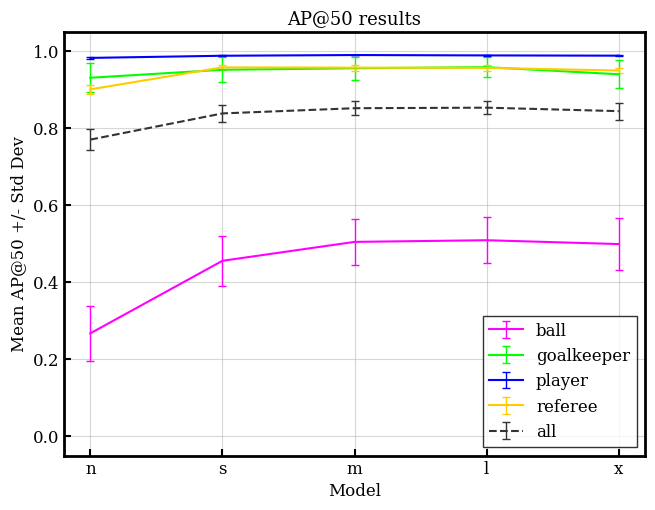

In [20]:
plt.figure(figsize=(7.5, 5.5))
plt.title("AP@50 results", fontsize=13)
plt.xlabel("Model")
plt.ylabel("Mean AP@50 +/- Std Dev")
plt.tick_params(direction="in", length=5, width=1.5)
plt.grid(alpha=0.5)
axxx = plt.gca()
for spine in axxx.spines.values():
    spine.set_linewidth(2) 

x = []
data_points = {}
        
for class_name in list(CLASS_NAMES.values()) + ["all"]:
    data_points[class_name] = {
        "y": [],
        "yerr": []
    }

for model, all_scores in results["AP50s"].items():
    x.append(model)

    for class_name, class_scores in all_scores.items():
        min_ = np.min(class_scores)
        max_ = np.max(class_scores)
        mean = np.mean(class_scores)
        std = np.std(class_scores)

        data_points[class_name]["y"].append(mean)
        data_points[class_name]["yerr"].append(std)

for i, (class_name, data) in enumerate(data_points.items()):
    plt.errorbar(
        x, data["y"], data["yerr"], capsize=3, elinewidth=1, linewidth=1.5,
        color=CHART_COLORS[i],
        linestyle='--' if class_name == "all" else '-',
        label=class_name
    )
    
plt.legend(loc='lower right', fancybox=False, edgecolor="black")
plt.ylim(-0.05, 1.05)
plt.show()

---

> ### `3.3` Analysis of the selected model

Based on the `mAP@50` metrics reported in the chart above in a qualitative fashion (there are no confidence intervals), we selected the model `m`, as it is the best compromise between performance and accuracy.

To train the selected model on the full dataset used for K-fold validation, run the following command: `python3 train-single-fold.py --model-size m --batch-size 14 --dataset refined --fold 0` (in particular, `--fold 0` specifies to use the full dataset).

Once the best model is ready, we can proceed to analyze its metrics on the never-seen test set.

> ---

> #### `3.3.1` Collect the test metrics

In [21]:
# The number is the corresponding index in the curves_results array provided by YOLO
curves = [
    ("Precision-Confidence", 2),
    ("Recall-Confidence", 3),
    ("Precision-Recall", 0)
]

results = recursive_dict()
results_dir = Path.cwd().parent / "results"
results_file = results_dir / "test.json"

if results_file.is_file():
    with open(results_file, "r") as f:
        results = json.load(f, object_hook=custom_decoder)
        print(f"Test results loaded from {results_file}")
else:
    dataset_name = f"data=refined-folds={NUM_FOLDS}-seed={SEED}"

    # Perform the test
    model_path = results_dir / "final-model" / "weights" / "best.pt"
    validation_config_path = DATASETS_PATH / dataset_name / "full" / "config.yaml"
    
    model = YOLO(model_path, task="detect")
    metrics = model.val(
        data=validation_config_path,
        imgsz=640,
        batch=dict(batch_config)["m"],
    )

    # Compute the metrics
    confusion_matrix = metrics.confusion_matrix.to_df(normalize=True).drop(columns=["Predicted"])
    results["confusion-matrix"] = confusion_matrix

    for class_id, class_name in CLASS_NAMES.items():
        results["AP50s"][class_name] = metrics.box.all_ap[class_id][0]

        for curve_name, curve_index in curves:
            results["curves"][curve_name][class_name]["x"] = metrics.curves_results[curve_index][0]
            results["curves"][curve_name][class_name]["y"] = metrics.curves_results[curve_index][1][class_id]
    results["AP50s"]["all"] = metrics.box.map50

    # Save the results dictionary in a json file
    with open(results_file, "w") as f:
        json.dump(results, f, cls=CustomEncoder)
    print(f"Test results saved to {results_file}")

    # Delete the temporary files created by the YOLO framework
    runs_dir = Path.cwd() / "runs"
    if runs_dir.is_dir():
        shutil.rmtree(runs_dir)

Ultralytics 8.3.163 🚀 Python-3.10.12 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7787MiB)
YOLO11m summary (fused): 125 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 165.0±23.8 MB/s, size: 70.2 KB)


val: Scanning /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/full/val/labels... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:0

val: New cache created: /home/fra/Desktop/IS/datasets/data=refined-folds=5-seed=999/full/val/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]


                   all         80       1900      0.908      0.782      0.827      0.575
                  ball         70         70      0.786      0.271      0.388      0.195
            goalkeeper         55         58      0.931      0.966      0.955      0.658
                player         80       1589      0.967      0.964       0.99      0.787
               referee         80        183       0.95      0.926      0.976      0.661
Speed: 1.9ms preprocess, 15.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/val
Test results saved to /home/fra/Desktop/IS/results/test.json


> ---

> #### `3.3.2` AP@50

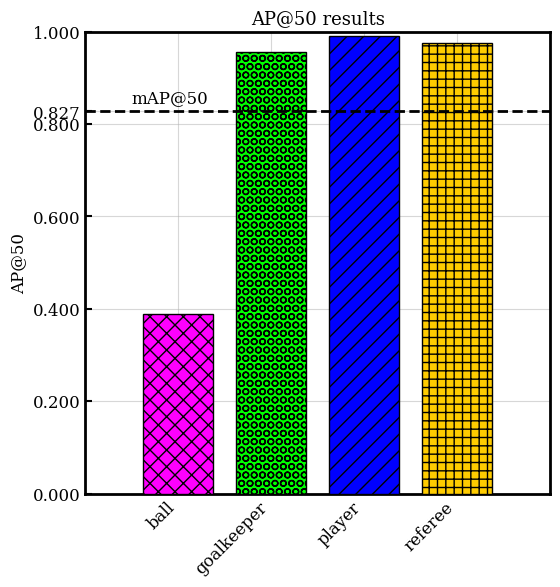

In [22]:
plt.title("AP@50 results", fontsize=13)
plt.ylabel("AP@50")
plt.tick_params(direction="in", length=5, width=1.5)
plt.grid(alpha=0.5)
axxx = plt.gca()
for spine in axxx.spines.values():
    spine.set_linewidth(2)

barwidth = 0.75
spacing = 1

hatches = ["XX", "OO", "//", "++", ".."]

metrics = results["AP50s"].copy()
mean = metrics.pop("all")

x_positions = np.arange(len(metrics))
x_values = x_positions * spacing

# Plot bars
for i, (label, value) in enumerate(metrics.items()):
    plt.bar(
        x_values[i], value,
        hatch=hatches[i % len(hatches)],
        width=barwidth,
        color=CHART_COLORS[i % len(CHART_COLORS)],
        edgecolor='black',
        zorder=3
    )

# Add horizontal dashed line for "all" (mAP@50)
plt.axhline(y=mean, color='black', linestyle='--', linewidth=2, zorder=4)
plt.yticks(list(plt.yticks()[0]) + [mean])  # Add custom y-tick
plt.text(
    x=-0.5,
    y=mean + 0.02,
    s="mAP@50",
    color='black'
)

labels = list(metrics.keys())
plt.xticks(x_values, labels, rotation=45, ha='right')

plt.ylim(0, 1)
plt.xlim([x_values[0] - 1, x_values[-1] + 1])
plt.show()

> ---

> #### `3.3.3` Confusion matrix

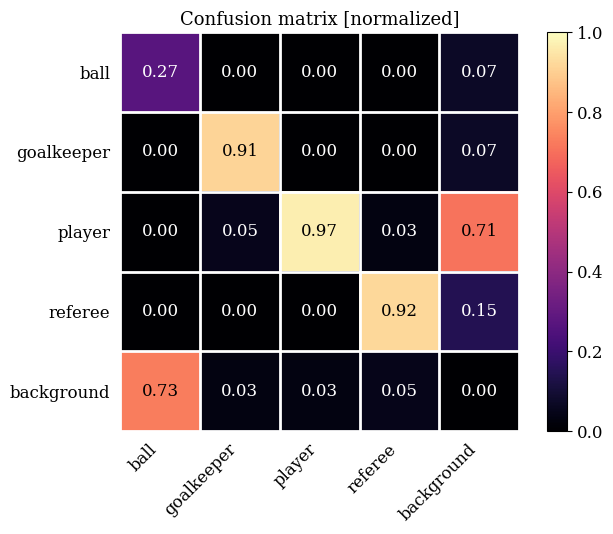

In [23]:
confusion_matrix_df = results["confusion-matrix"]
confusion_matrix_df.index = confusion_matrix_df.columns
df = confusion_matrix_df

fig, ax = plt.subplots(figsize=(7, 5.5))
im = ax.imshow(df.values, cmap='magma', vmin=0, vmax=1)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)

# Set axis labels
ax.set_xticks(np.arange(len(df.columns)))
ax.set_yticks(np.arange(len(df.index)))
ax.set_xticklabels(df.columns, rotation=45, ha='right')
ax.set_yticklabels(df.index)

# Draw gridlines (cell borders)
for edge, spine in ax.spines.items():
    spine.set_visible(False)

ax.set_xticks(np.arange(df.shape[1]+1)-0.5, minor=True)
ax.set_yticks(np.arange(df.shape[0]+1)-0.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax.tick_params(which="both", bottom=False, left=False)

# Annotate each cell with the numeric value
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        val = df.iloc[i, j]
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white' if val < 0.5 else 'black')

plt.title("Confusion matrix [normalized]")
plt.tight_layout()
plt.show();

> ---

> #### `3.3.4` Precision-Recall curves

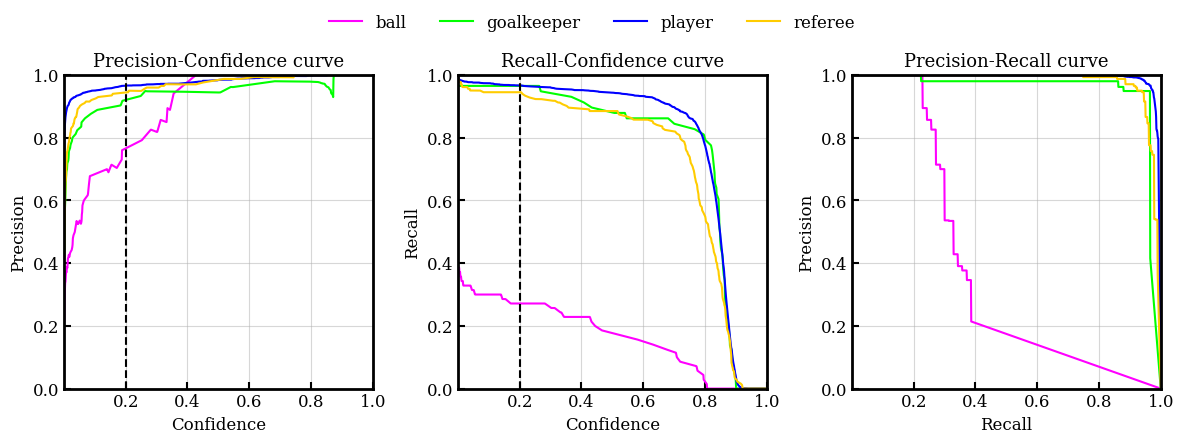

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4.5))
axs = axs.flatten()

legend_handles = []
legend_labels = []

for idx, (curve_name, classed_curves) in enumerate(results["curves"].items()):
    ax = axs[idx]
    ax.set_title(f"{curve_name} curve", fontsize=13)
    ax.set_xlabel(curve_name.split("-")[1])
    ax.set_ylabel(curve_name.split("-")[0])
    ax.tick_params(direction="in", length=5, width=1.5)
    ax.grid(alpha=0.5)
    
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Set the border thickness

    for i, (class_name, data_points) in enumerate(classed_curves.items()):
        line, = ax.plot(data_points["x"], data_points["y"], label=CLASS_NAMES[i], color=CHART_COLORS[i])

        if idx == 0:
            legend_handles.append(line)
            legend_labels.append(CLASS_NAMES[i])
    
    # Add vertical dashed line at conf = 0.2 for the first two curves
    if idx in [0, 1]:
        ax.axvline(x=0.2, color='black', linestyle='--', linewidth=1.5)
    
    ax.set_xlim(0, 1)
    ax.set_xticks([0.2 * i for i in range(1, 6)])  # Avoids double 0.0 tick
    ax.set_ylim(0, 1)

fig.legend(legend_handles, legend_labels, loc='upper center', ncol=len(CLASS_NAMES), frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.925])  # Leave space at the top for the legend
plt.show()

> ---

As evident from both the confusion matrix and the Precision-Recall curves, the model struggles with finding the ball (when there is a ball, the model only finds it approximately `1/4` of the times). 

This is understandable since: 
- The ball is extremely little compared to other objects in the image
- There are multiple ball-looking objects in the image (e.g., penalty and kick-off spots, balls outside of the field, people's heads, ...)
- There is at most one ball per image, which y that the model has seen relatively few balls compared to other classes

Finally, the curves suggest using a confidence value of around `0.2` for a good compromise between precision and recall when using the model to perform inference.

<br>
<br>
<br>

---

## `4` Demo

In [25]:
IMGSZ = 640
IOU = 0.5
CONF = 0.2

---

> ### `4.1` Predict a single image


image 1/1 /home/fra/Desktop/IS/datasets/refined/images/7a13855f-xXmTSb6LzR02QZwdIvHsnZMVFTyXBi4Ph6o3ocBSAqEFqgFbEg.jpg: 640x640 1 goalkeeper, 19 players, 2 referees, 17.9ms
Speed: 0.9ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


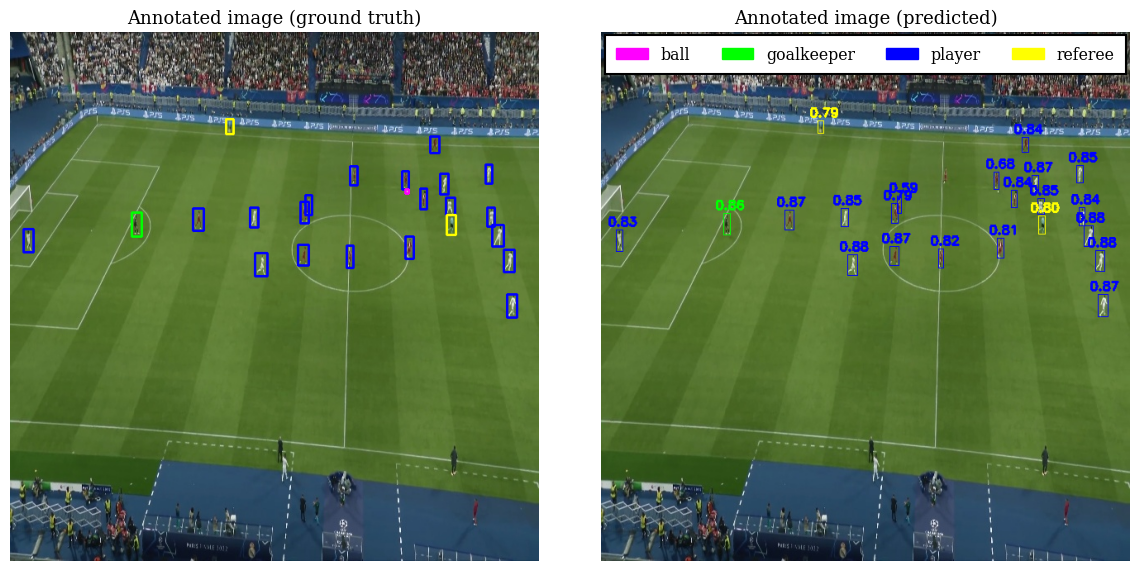

In [26]:
def draw_yolo_predictions(image, predictions):
    """
    Draws bounding box predictions from a YOLO model on the given image, 
    including class-specific colors and confidence scores.

    Args:
        image (numpy.ndarray): The image on which to draw the predicted bounding boxes.
        predictions (Results): A YOLO model prediction result containing bounding boxes, classes, and confidences.

    Returns:
        numpy.ndarray: The image with predicted bounding boxes and confidence scores drawn.
    """
    for box in predictions[0].boxes:
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        class_id = int(box.cls[0])
        class_color = CLASS_COLORS.get(class_id)
        conf = float(box.conf[0])
        label = f"{conf:.2f}"
        
        cv2.rectangle(image, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), class_color)
        cv2.putText(image, label, (xyxy[0] - 10, xyxy[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, class_color, 2)
    
    return image

image_filenames = os.listdir(refined_dataset_path / "images")
random_image_path = refined_dataset_path / "images" / random.choice(image_filenames)
random_label_path = refined_dataset_path / "labels" / (random_image_path.stem + ".txt")

model_path = results_dir / "final-model" / "weights" / "best.pt"
model = YOLO(model_path, task="detect")

predictions_refined = model.predict(
    source=random_image_path,
    imgsz=IMGSZ,
    conf=CONF,
    iou=IOU
)

original_image = cv2.imread(random_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

draw_images_hsplit_layout(
    draw_yolo_annotations(original_image.copy(), random_label_path), "Annotated image (ground truth)",
    draw_yolo_predictions(original_image.copy(), predictions_refined), "Annotated image (predicted)"
)

---

> ### `4.2` Predict a video

In [27]:
# Helper functions

class TEAM(Enum):
    A = 0
    B = 1
    
def get_dominant_color(patch):
    """
    Computes the dominant color of an image patch by averaging pixel values.

    Args:
        patch (np.ndarray): Image patch in BGR format.

    Returns:
        np.ndarray: Dominant color in RGB format.
    """
    mean_color = patch.mean(axis=(0, 1))
    return mean_color[::-1] # Convert to RGB

def detect_teams(frame, player_boxes, prev_centroids=None):
    """
    Clusters players into two teams based on torso color and spatial location.

    Args:
        frame (np.ndarray): Original video frame (in BGR format).
        player_boxes (list of list of int): List of bounding boxes [x1, y1, x2, y2] for each player.
        prev_centroids (list of np.ndarray): RGB color centroids of each team from the previous frame.

    Returns:
        Tuple:
            - labels (np.ndarray): Array indicating team assignment (0 or 1) for each player.
            - cluster_centroids (list of np.ndarray): RGB color centroids for each detected team.
            - sil_score (float): Silhouette score for the clustering (-1 if not computable).
    """
    h_img, w_img = frame.shape[:2]
    dominant_colors = []
    patch_size = 0.2

    for (x1, y1, x2, y2) in player_boxes:
        
        # Cut a patch centered on the torso of the players
        box_w, box_h = x2 - x1, y2 - y1
        cx = x1 + box_w // 2
        cy = y1 + box_h // 3

        patch = frame[max(y1, cy - int(patch_size * box_h)):min(y2, int(cy + patch_size * box_h)),
                      max(x1, cx - int(patch_size * box_w)):min(x2, int(cx + patch_size * box_w))]
                
        # Extract the dominant color of the patch
        dominant_color = get_dominant_color(patch)
        dominant_colors.append(dominant_color)

    # Convert the list of domimant colors to HSV space for better clustering
    hsv_colors = cv2.cvtColor(
        np.array(dominant_colors)
            .reshape(-1, 1, 3) # Convert to match OpenCV format
            .astype(np.uint8),
        cv2.COLOR_RGB2HSV
    ).reshape(-1, 3) # Flattens back to a 2D array: shape (N, 3), each row is [H, S, V]
    
    # Cluster the players based on the following (normalized) values:
    # - Player's torso dominant color Hue (ranges 0 to 179)
    # - Player's torso dominant color Saturation (ranges 0 to 255)
    features = [[hsv[0]/179, hsv[1]/255] for hsv in hsv_colors]

    kmeans = KMeans(n_clusters=2, random_state=SEED).fit(features)
    team_labels = kmeans.labels_
    sil_score = silhouette_score(features, team_labels)

    # Calculate each cluster's centroid as the mean of the dominant colors of the players in the cluster
    cluster_centroids = [
        np.mean([dominant_colors[i] for i in range(len(team_labels)) if team_labels[i] == cluster], axis=0) for cluster in [0, 1]
    ]

    if prev_centroids:
        prev_centroid_team_a, prev_centroid_team_b = prev_centroids
        curr_centroid_team_a, curr_centroid_team_b = cluster_centroids
        
        # Distance if team assignments stayed the same
        dist_a_same = np.linalg.norm(curr_centroid_team_a - prev_centroid_team_a)
        dist_b_same = np.linalg.norm(curr_centroid_team_b - prev_centroid_team_b)
        dist_same = dist_a_same + dist_b_same
        
        # Distance if team assignments flipped
        dist_a_flipped = np.linalg.norm(curr_centroid_team_b - prev_centroid_team_a)
        dist_b_flipped = np.linalg.norm(curr_centroid_team_a - prev_centroid_team_b)
        dist_flipped = dist_a_flipped + dist_b_flipped

        # Colors flipped
        if dist_flipped < dist_same:
            team_labels = 1 - team_labels
            cluster_centroids = cluster_centroids[::-1]

    return team_labels, cluster_centroids, sil_score

def calculate_team_in_possession(ball_box, player_boxes, team_labels):
    """
    Determines which team is currently in possession of the ball based on proximity.

    Args:
        ball_box (tuple): Bounding box of the ball in (x1, y1, x2, y2) format.
        player_boxes (list of tuples): List of player bounding boxes in (x1, y1, x2, y2) format.
        team_labels (list of TEAM enums): Team label for each player, corresponding to the order of player_boxes.

    Returns:
        TEAM enum: The team label of the player closest to the ball.
    """
    bx1, by1, bx2, by2 = ball_box
    ball_center = np.array([(bx1 + bx2) / 2, (by1 + by2) / 2])

    player_feets = np.array([[(x1 + x2) / 2, y2] for x1, y1, x2, y2 in player_boxes])

    # Compute distances from the ball to each player's feet
    distances = np.linalg.norm(player_feets - ball_center, axis=1)

    closest_idx = np.argmin(distances)
    return TEAM(team_labels[closest_idx])

def process_video(input_video_path, output_video_path):
    """
    Processes a video to detect and annotate players, ball, and referees, 
    estimate team possession, and save the annotated output.

    Args:
        input_video_path (str | pathlib.Path): Path to the input video file.
        output_video_path (str | pathlib.Path): Path where the processed video will be saved.
    """
    
    # Initialize the best model
    model_path = results_dir / "final-model" / "weights" / "best.pt"
    model = YOLO(model_path, task="detect")

    # Initialize video input and output streams
    cap = cv2.VideoCapture(input_video_path)
    width, height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    # Style supervision's annotators
    ball_annotator = sv.TriangleAnnotator(
        base=25, height=20, color=sv.Color.ROBOFLOW, outline_thickness=2, outline_color=sv.Color.BLACK)
    goalkeeper_annotator = sv.EllipseAnnotator(thickness=3, color=sv.Color.GREEN)
    referee_annotator = sv.EllipseAnnotator(thickness=3, color=sv.Color.YELLOW)
    team_a_annotator = sv.EllipseAnnotator(thickness=3, color=sv.Color.BLUE)
    team_b_annotator = sv.EllipseAnnotator(thickness=3, color=sv.Color.RED)

    sil_scores = []
    prev_centroids = []
    prev_team_in_possession = TEAM.A
    possession_times = {
        TEAM.A: 0,
        TEAM.B: 0,
    }

    # Loop each frame of the input video stream
    progress_bar = tqdm(total=total_frames, desc="Processing video", unit="frame")
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        progress_bar.update(1)

        # Resize the frames to 1:1 aspect ratio for prediction
        square_frame = cv2.resize(frame, (IMGSZ, IMGSZ))
        results = model.predict(square_frame, imgsz=IMGSZ, iou=IOU, conf=CONF, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(results)

        # Scale the predicted boxes back to the original aspect ratio
        scale_x, scale_y = width / IMGSZ, height / IMGSZ
        detections.xyxy[:, [0, 2]] *= scale_x
        detections.xyxy[:, [1, 3]] *= scale_y

        # Get the predictions
        ball = detections[detections.class_id == 0]
        goalkeepers = detections[detections.class_id == 1]
        referees = detections[detections.class_id == 3]
        players = detections[detections.class_id == 2]

        # Annotate the frame
        annotated_frame = ball_annotator.annotate(frame.copy(), detections=ball)
        annotated_frame  = goalkeeper_annotator.annotate(annotated_frame, detections=goalkeepers)
        annotated_frame  = referee_annotator.annotate(annotated_frame, detections=referees)

        # Separate the players into two teams
        player_boxes = players.xyxy.astype(int).tolist()
        team_labels, cluster_centroids, sil_score = detect_teams(frame.copy(), player_boxes, prev_centroids)
        prev_centroids = cluster_centroids
        sil_scores.append(sil_score)

        team_a_boxes = np.array([player_boxes[i] for i in range(len(team_labels)) if team_labels[i] == 0])
        team_b_boxes = np.array([player_boxes[i] for i in range(len(team_labels)) if team_labels[i] == 1])

        team_a_detections = sv.Detections(xyxy=team_a_boxes, class_id=np.array([2] * len(team_a_boxes)))
        team_b_detections = sv.Detections(xyxy=team_b_boxes, class_id=np.array([2] * len(team_b_boxes)))

        # Annotate the frame using different colors for each team
        annotated_frame = team_a_annotator.annotate(annotated_frame, detections=team_a_detections)
        annotated_frame = team_b_annotator.annotate(annotated_frame, detections=team_b_detections)

        # If there is a ball, update the ball possession statistic,
        #  otherwise assume it's still in the hands of the previous team
        ball_boxes = ball.xyxy.astype(int).tolist()
        if len(ball_boxes) >= 1:
            team_in_possession = calculate_team_in_possession(ball_boxes[0], player_boxes, team_labels)
            possession_times[team_in_possession] += 1
            prev_team_in_possession = team_in_possession
        else:
            possession_times[prev_team_in_possession] += 1

        total_possession_times = possession_times[TEAM.A] + possession_times[TEAM.B]
        team_a_percent = int(possession_times[TEAM.A] / total_possession_times * 100)
        team_b_percent = int(possession_times[TEAM.B] / total_possession_times * 100)

        cv2.putText(annotated_frame, f"Possession of Team A: {team_a_percent}%", (1320, 100),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 170, 0), 4 if prev_team_in_possession == TEAM.A else 2)
        cv2.putText(annotated_frame, f"Possession of Team B: {team_b_percent}%", (1320, 138),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 4 if prev_team_in_possession == TEAM.B else 2)

        out.write(annotated_frame)

    cap.release()
    out.release()
    progress_bar.close()

    print(f"\nMean silhouette score: {np.mean(sil_scores):.4f} +/- {np.std(sil_scores):.4f}")

In [28]:
demo_path = Path.cwd().parent / "demo"
input_video_path = demo_path / "input.mp4"
output_video_path = demo_path / "output.mp4"
process_video(input_video_path, output_video_path)

Processing video:   0%|          | 0/750 [00:00<?, ?frame/s]


Mean silhouette score: 0.7723 +/- 0.0477


---

> ### `4.3` Team detection visualization

> ---

> #### `4.3.1` Isolate the players

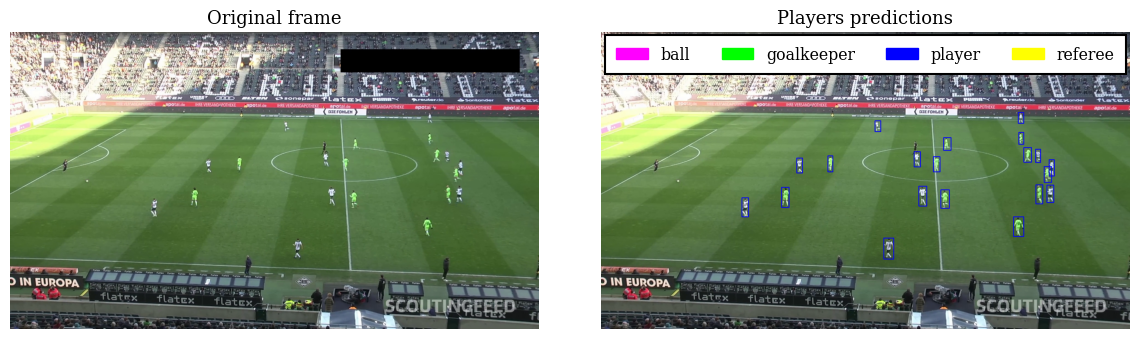

In [29]:
model_path = results_dir / "final-model" / "weights" / "best.pt"
model = YOLO(model_path, task="detect")

frame = cv2.imread("media/team_detection_original_frame.png")
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
height, width = frame.shape[:2]

# Resize the frame to 1:1 aspect ratio
square_frame = cv2.resize(frame, (IMGSZ, IMGSZ))
results = model.predict(square_frame, imgsz=IMGSZ, iou=IOU, conf=CONF, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

# Scale the predicted boxes back to the original aspect ratio
scale_x, scale_y = width / IMGSZ, height / IMGSZ
detections.xyxy[:, [0, 2]] *= scale_x
detections.xyxy[:, [1, 3]] *= scale_y

# Get the predictions
players = detections[detections.class_id == 2]
player_boxes = players.xyxy.astype(int).tolist()

# Annotate the frame
player_annotator = sv.BoxAnnotator(thickness=2, color=sv.Color.RED) # = BLUE in the RGB space
annotated_frame = player_annotator.annotate(frame.copy(), detections=players)

draw_images_hsplit_layout(
    frame.copy(), "Original frame",
    annotated_frame, "Players predictions"
)

> ---

In [30]:
# Execute all the next steps in one cell, then explain them later

dominant_colors = []
patch_size = 0.2

patches = []
dominant_colors_patches = []

for i, (x1, y1, x2, y2) in enumerate(player_boxes):
    
    # Cut a patch centered on the torso of the players
    box_w, box_h = x2 - x1, y2 - y1
    cx = x1 + box_w // 2
    cy = y1 + box_h // 3

    patch = frame[max(y1, cy - int(patch_size * box_h)):min(y2, int(cy + patch_size * box_h)),
                  max(x1, cx - int(patch_size * box_w)):min(x2, int(cx + patch_size * box_w))]

    patches.append(patch)
            
    # Extract the dominant color of the patch
    dominant_color = get_dominant_color(patch)
    dominant_colors.append(dominant_color)

    # [For visualization] Create a patch filled with the dominant color
    dominant_color_patch = np.full((y2 - y1, x2 - x1, 3), dominant_color, dtype=np.uint8)
    dominant_color_patch = cv2.cvtColor(dominant_color_patch, cv2.COLOR_BGR2RGB)
    dominant_colors_patches.append(dominant_color_patch)

# Convert the list of domimant colors to HSV space for better clustering
hsv_colors = cv2.cvtColor(
    np.array(dominant_colors)
        .reshape(-1, 1, 3) # Convert to match OpenCV format
        .astype(np.uint8),
    cv2.COLOR_RGB2HSV
).reshape(-1, 3) # Flattens back to a 2D array: shape (N, 3), each row is [H, S, V]

# Cluster the players based on the following (normalized) values:
# - Player's torso dominant color Hue (ranges 0 to 179)
# - Player's torso dominant color Saturation (ranges 0 to 255)
features = [[hsv[0]/179, hsv[1]/255] for hsv in hsv_colors]

kmeans = KMeans(n_clusters=2, random_state=SEED).fit(features)
team_labels = kmeans.labels_
sil_score = silhouette_score(features, team_labels)

> ---

> #### `4.3.2` Extract the patches and the dominant colors

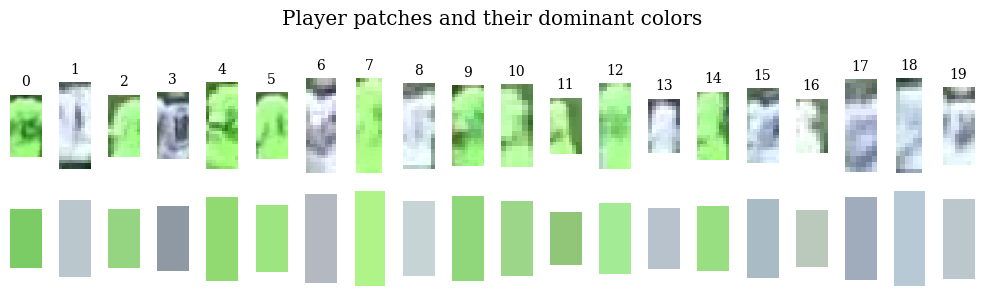

In [31]:
fig1 = plt.figure(figsize=(10, 3))

num_patches = len(patches)
for i in range(num_patches):
    patch = patches[i]
    dom_color_patch = dominant_colors_patches[i]

    ax1 = fig1.add_subplot(2, num_patches, i + 1)
    ax1.imshow(patch)
    ax1.axis("off")
    ax1.set_title(f"{i}", fontsize=10)

    ax2 = fig1.add_subplot(2, num_patches, num_patches + i + 1)
    ax2.imshow(dom_color_patch)
    ax2.axis("off")

fig1.suptitle("Player patches and their dominant colors")
plt.tight_layout()
plt.show()

> ---

> #### `4.3.3` Visualize the feature space

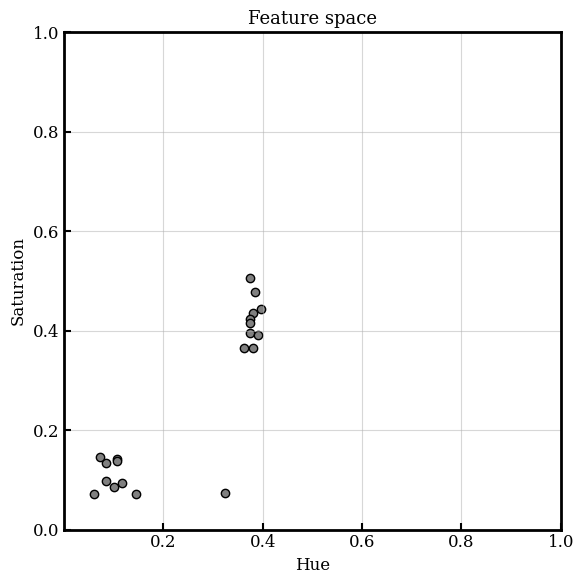

In [32]:
h_vals = [hs[0] for hs in features]
s_vals = [hs[1] for hs in features]

fig, ax = plt.subplots()

ax.scatter(h_vals, s_vals, c='gray', edgecolors='black')
ax.set_xlabel("Hue")
ax.set_ylabel("Saturation")
ax.set_title("Feature space")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([0.2 * i for i in range(1, 6)]) # Avoids double 0.0 tick

ax.tick_params(direction="in", length=5, width=1.5)
ax.grid(alpha=0.5)

for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()

> ---

> #### `4.3.4` Visualize the final clusters

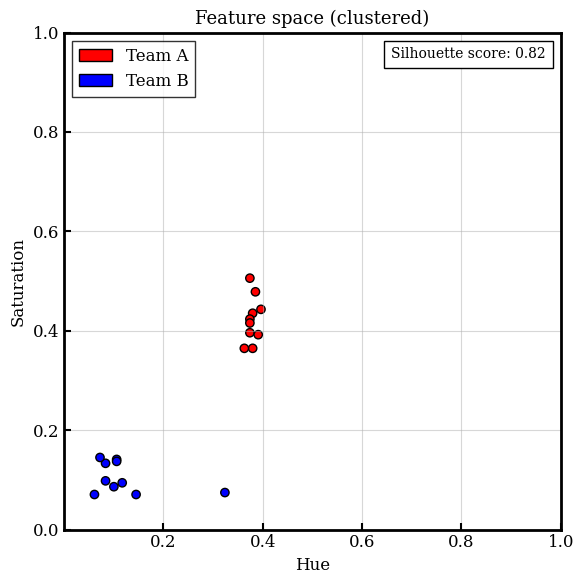

In [33]:
colors_by_team = ['red' if label == 0 else 'blue' for label in team_labels]

fig, ax = plt.subplots()

ax.scatter(h_vals, s_vals, c=colors_by_team, edgecolors='black')

ax.set_xlabel("Hue")
ax.set_ylabel("Saturation")
ax.set_title("Feature space (clustered)")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([0.2 * i for i in range(1, 6)])  # Avoids double 0.0 tick

ax.tick_params(direction="in", length=5, width=1.5)
ax.grid(alpha=0.5)
for spine in ax.spines.values():
    spine.set_linewidth(2)

legend_elements = [
    mpatches.Patch(facecolor='red', edgecolor='black', label='Team A'),
    mpatches.Patch(facecolor='blue', edgecolor='black', label='Team B')
]
ax.legend(loc='upper left', fancybox=False, edgecolor="black", handles=legend_elements)

ax.text(
    0.97, 0.97, f'Silhouette score: {sil_score:.2f}',
    horizontalalignment='right',
    verticalalignment='top',
    transform=ax.transAxes,
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5')
)

plt.tight_layout()
plt.show()

<br>
<br>
<br>